# Example-01: Estimation of parameters (harmonic sum)

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Estimate parameters and standard errors (with random frequency)

# Set parameters

length = 1024

# Set window

w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Set noise parameters

s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data

t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.1), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.5)])

# Estimate parameters and errors (direct)

p1, s1 = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate parameters and errors (automatic)

p2, s2 = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)

# Estimate errors (average over noise realizations)

box = []
for _ in range(8192):
    y = x + s_x.reshape(-1, 1)*torch.randn_like(x, dtype=dtype, device=device)
    out, _ = Decomposition.harmonic_sum(0.12 + 1.0E-5*torch.randn(1, dtype=dtype, device=device), w.window, y)
    box.append(out)    
box = torch.stack(box).std(-3)

# Compare parameters

print(p1)
print(p2)
print()

# Compare errors

print(s1)
print(s2)
print(box)
print()

tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)
tensor([[2.487510441567e-01, -2.495835633644e-02, 2.500000030401e-01, 1.000000075225e-01],
        [6.581869317981e-01, -3.595691566478e-01, 7.500000104014e-01, 4.999999965175e-01]],
       dtype=torch.float64)

tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.822920460161e-03, 8.447543997630e-03, 2.706329386825e-03, 3.394245931339e-02],
        [1.157996334008e-02, 2.118073069991e-02, 5.412658773651e-04, 3.217800267359e-02]],
       dtype=torch.float64)
tensor([[2.802782711160e-03, 8.356512643284e-03, 2.674990280570e-03, 3.360273931306e-02],
        [1.148432343642e-02, 2.099971340980e-02, 5.490713943031e-04, 

In [4]:
# Estimate amplitude and phase from cos & sin values
# Note, for error propagation cos & sin are treated as independent random variables (which is not true)

c, s, *_ = p1.T
sigma_c, sigma_s, *_ = s1.T

value, error = Decomposition.amplitude(c, s, sigma_c=sigma_c, sigma_s=sigma_s)
print(value)
print(error)

value, error = Decomposition.phase(c, s, sigma_c=sigma_c, sigma_s=sigma_s)
print(value)
print(error)

tensor([2.500000030401e-01, 7.500000104014e-01], dtype=torch.float64)
tensor([2.932693465157e-03, 1.436625917563e-02], dtype=torch.float64)
tensor([1.000000075225e-01, 4.999999965175e-01], dtype=torch.float64)
tensor([3.364025846168e-02, 2.586561821930e-02], dtype=torch.float64)


In [5]:
# Estimate cos & sin amplitudes for knowns frequencies using OLS

basis = torch.tensor([0.12], dtype=dtype, device=device)
for signal in x:
    out, _ = Decomposition.fit_ols(signal, basis)
    print(out)

tensor([[2.487510413195e-01, -2.495835416171e-02]], dtype=torch.float64)
tensor([[6.581869214178e-01, -3.595691539531e-01]], dtype=torch.float64)


In [7]:
# Estimate cos & sin amplitudes for a given frequency dictionary using OLS and OMP

signal  = 0.50*torch.cos(2.0*numpy.pi*1*0.12*t) + 0.10*torch.sin(2.0*numpy.pi*1*0.12*t)
signal += 0.10*torch.cos(2.0*numpy.pi*3*0.12*t) + 0.05*torch.sin(2.0*numpy.pi*3*0.12*t)
signal += 0.01*torch.rand_like(signal)

matrix = Filter.make_matrix(signal.unsqueeze(0))
_, sigma = Filter.svd_optimal(matrix[:, :32])
sigma = sigma.item()

basis = torch.tensor([*Frequency.harmonics(10, [0.12]).values()], dtype=dtype, device=device)

out, _ = Decomposition.fit_ols(signal, basis, length=256)
print(out)
print()

out, _ = Decomposition.fit_omp(signal, basis, tol=3.0*sigma, length=256)
print(out)
print()

tensor([[ 5.001098124591e-01,  9.996363148893e-02],
        [-1.523856660461e-04,  2.912083559217e-04],
        [ 1.003110086310e-01,  4.989457119988e-02],
        [-5.107793392398e-04, -2.870064917945e-04],
        [-2.640687218915e-04, -2.915746286255e-04],
        [-3.330001018499e-04,  1.699976693743e-04],
        [-4.972470154018e-05,  3.717176652639e-04],
        [-1.328429993075e-04,  4.317467987948e-04],
        [ 3.044452875112e-04, -4.601302592127e-05],
        [ 6.158678239156e-04,  2.483680001817e-04]], dtype=torch.float64)

tensor([[5.001452935791e-01, 9.988767178799e-02],
        [0.000000000000e+00, 0.000000000000e+00],
        [1.002782503251e-01, 4.990379997897e-02],
        [0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00],
        [0.000000000000e+00, 0.000000000000e+00],
       

# Example-02: Estimation of parameters (harmonic sum & batched mode)

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Estimate parameters and errors for a batch of frequencies

# Set parameters

length = 1024

# Set window

w = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set noise parameters

s_x = torch.tensor([0.05, 0.01], dtype=dtype, device=device)
s_f = 1.0E-5

# Set data

t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10), 0.75*torch.cos(2.0*numpy.pi*0.12*t + 0.60)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25), 0.25*torch.cos(2.0*numpy.pi*0.24*t + 0.15)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10), 0.01*torch.cos(2.0*numpy.pi*0.36*t + 0.50)])
x = x1 + x2 + x3

# Compute parameters and errors for each frequency (direct)

p1a, s1a = Decomposition.harmonic_sum(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1b, s1b = Decomposition.harmonic_sum(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1c, s1c = Decomposition.harmonic_sum(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p1 = torch.stack([p1a, p1b, p1c])
s1 = torch.stack([s1a, s1b, s1c])

# Compute parameters and errors for each frequency (automatic)

p2a, s2a = Decomposition.harmonic_sum_automatic(0.12, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2b, s2b = Decomposition.harmonic_sum_automatic(0.24, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2c, s2c = Decomposition.harmonic_sum_automatic(0.36, w.window, x, error=True, sigma=s_x, sigma_frequency=s_f)
p2 = torch.stack([p2a, p2b, p2c])
s2 = torch.stack([s2a, s2b, s2c])

# Compute parameters and errors for each frequency (batched)

p3, s3 = Decomposition.harmonic_sum_batched(
    torch.tensor([0.12, 0.24, 0.36], dtype=dtype, device=device),
    w.window,
    x,
    error=True,
    sigma=s_x,
    sigma_frequency=torch.tensor([s_f, s_f, s_f], dtype=dtype, device=device))

# Compare errors

print(s1)
print(s2)
print(s3)

tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.706329386826e-03, 6.296499040365e-02],
         [5.628105253876e-04, 6.104693260486e-04, 5.412658773675e-04, 6.296490438044e-02]]],
       dtype=torch.float64)
tensor([[[2.822920601761e-03, 8.447544296222e-03, 2.706329386825e-03, 3.394245973862e-02],
         [1.363412168625e-02, 1.992058457734e-02, 5.412658773653e-04, 3.217800385559e-02]],

        [[2.820933989700e-03, 4.127929982633e-03, 2.706329386827e-03, 4.203956358381e-02],
         [1.318111090385e-03, 7.970572419377e-03, 5.412658773716e-04, 3.224269320318e-02]],

        [[2.711089283224e-03, 3.144152029843e-03, 2.

In [4]:
# Estimate parameters for a list of harmonics

# Set parameters

length = 2048

# Set window

w = Window.from_cosine(length, 4.0, dtype=dtype, device=device)

# Set data

t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
x1 = torch.stack([0.25*torch.cos(2.0*numpy.pi*0.12*t + 0.10)])
x2 = torch.stack([0.10*torch.cos(2.0*numpy.pi*0.24*t + 0.25)])
x3 = torch.stack([0.05*torch.cos(2.0*numpy.pi*0.36*t + 0.10)])
x = x1 + x2 + x3

# Set harmonics

f = 0.12
h = torch.tensor([*Frequency.harmonics(10, [f]).values()], dtype=dtype, device=device)

# Estimate parameters

param, _ = Decomposition.harmonic_sum_batched(h, w.window, x, error=False)

# Result (amplitude)

*_, a, _ = param.swapaxes(0, -1)
print(a.T)

tensor([[2.500000000000e-01],
        [1.000000000000e-01],
        [5.000000000000e-02],
        [2.623619031558e-16],
        [4.015512494878e-16],
        [3.147267753522e-16],
        [1.854150954133e-16],
        [1.135456674832e-16],
        [7.519772959361e-16],
        [2.807503616015e-16]], dtype=torch.float64)


# Example-03: Estimator bias

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

w1: 2.09465512e-05 2.2936407e-06
w2: 3.7373038e-09 4.98039843e-09


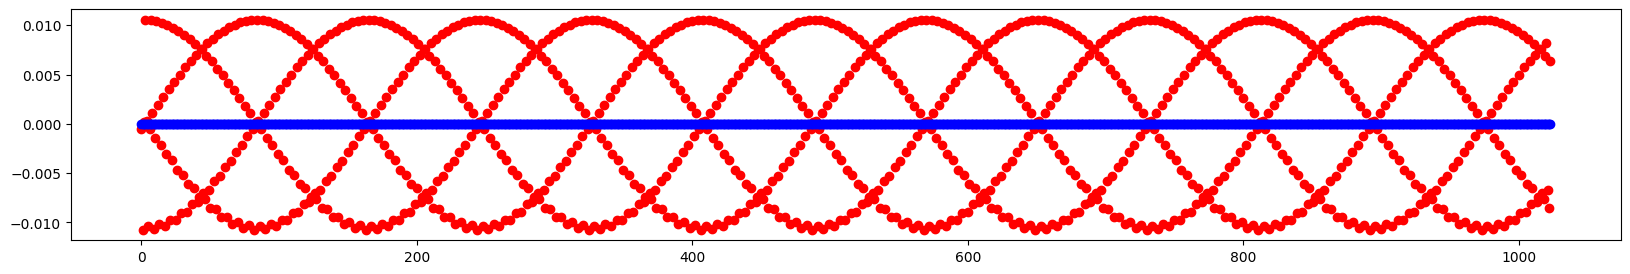

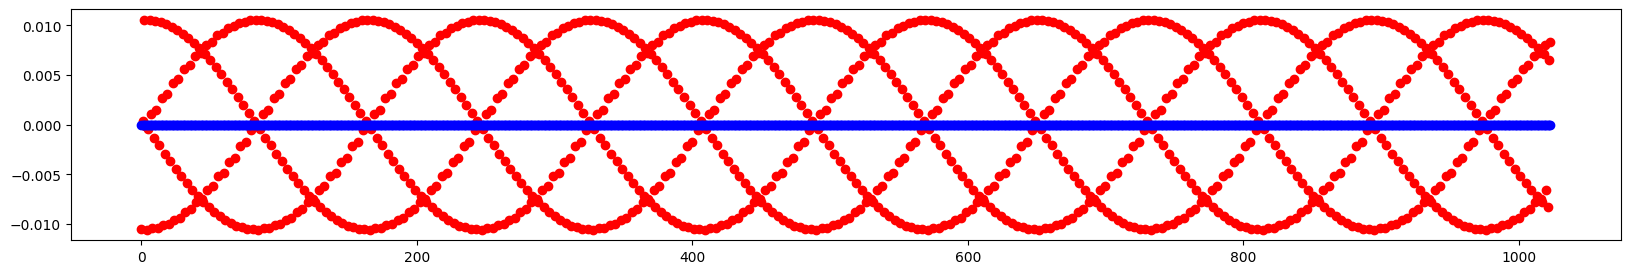

In [3]:
# Given a noise-free signal containing several components
# Parameters for a given frequency can be estimated using (weighted) harmonic sum
# Estimated values depend on the length used for estimation and as well as on the signal starting position
# In this example, estimator bias is explored
# Ensembling several estimators (fixed length and different starting position) in general will improve estimation accuracy (reduce bias)

# Set parameters

length = 8192

# Set signal

t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x = torch.stack([x])

# Set shift size for starting position

shift = 1

# Set window

w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 1.0, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Change window order, sample length and/or number of samples to observe convergents

limit = 1024
A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    
    y = x[:, step*shift: step*shift + 128]
    
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)
    
# Format result (amplitude is constant, while phase is shifted)

A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples

print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample

plt.figure(figsize=(20, 3))
plt.scatter(range(limit), (A1 - 1.00).cpu().numpy(), c='red')
plt.scatter(range(limit), (A2 - 1.00).cpu().numpy(), c='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.scatter(range(limit), (B1 - 0.25).cpu().numpy(), c='red')
plt.scatter(range(limit), (B2 - 0.25).cpu().numpy(), c='blue')
plt.show()

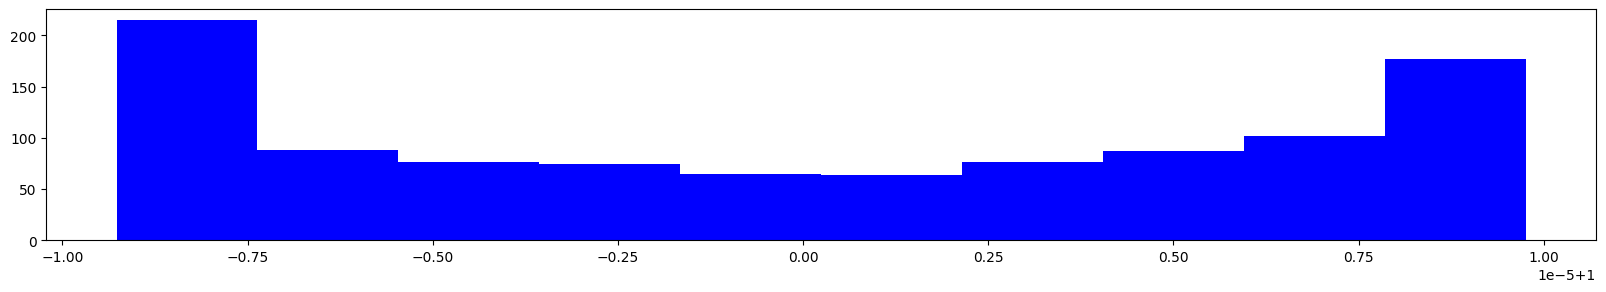

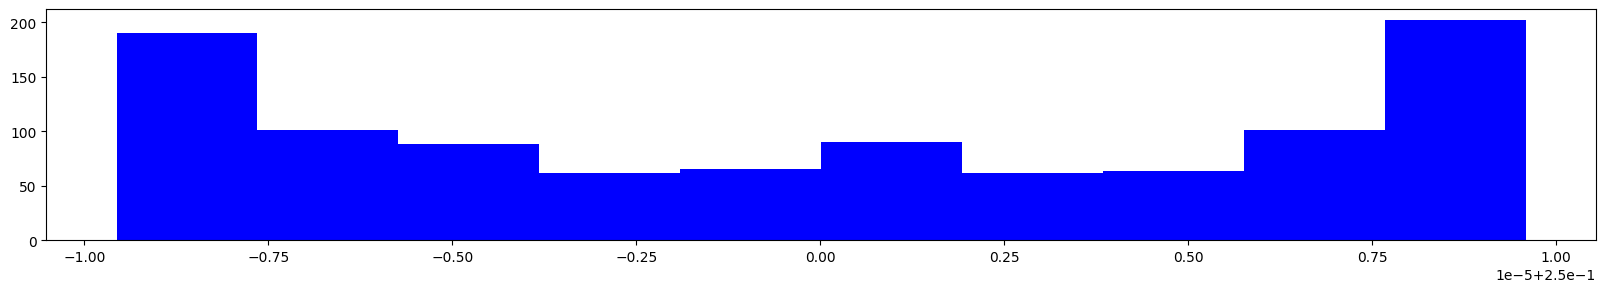

In [4]:
# Plot histogram

plt.figure(figsize=(20, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(20, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution is not normal (not random)
# It is not symmetric if signal containes more than one component

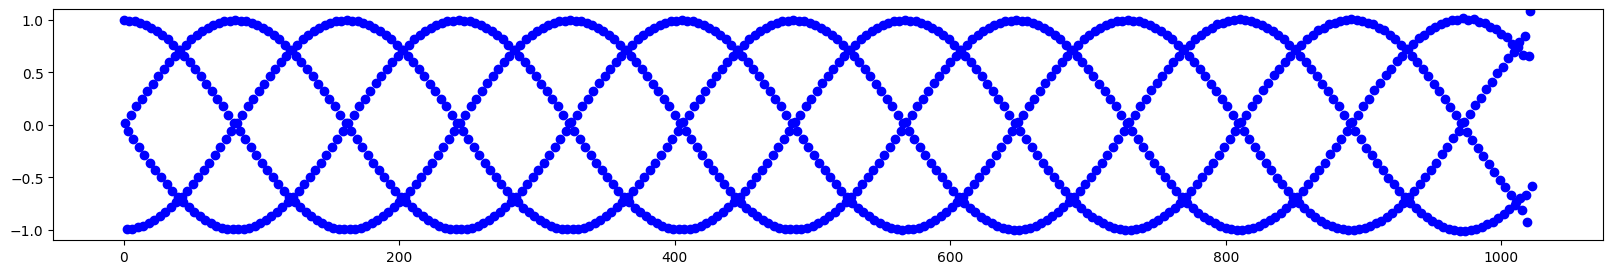

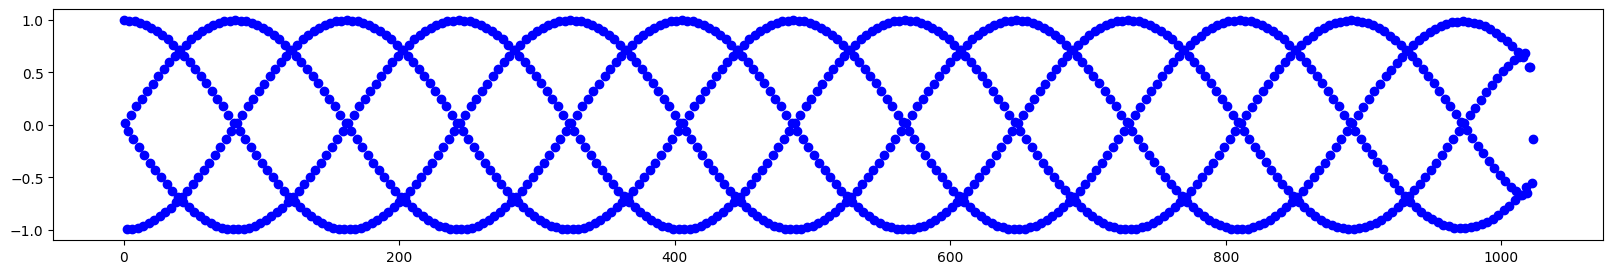

In [5]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten().cpu().numpy()
plt.figure(figsize=(20, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten().cpu().numpy()
plt.figure(figsize=(20, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

w1: 3.24955672e-06 2.90046061e-05
w2: 2.76861459e-05 2.81693374e-05


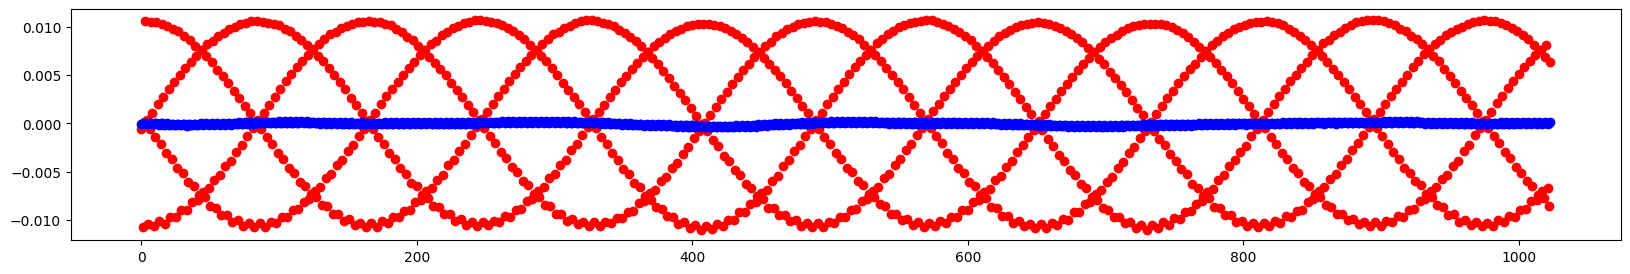

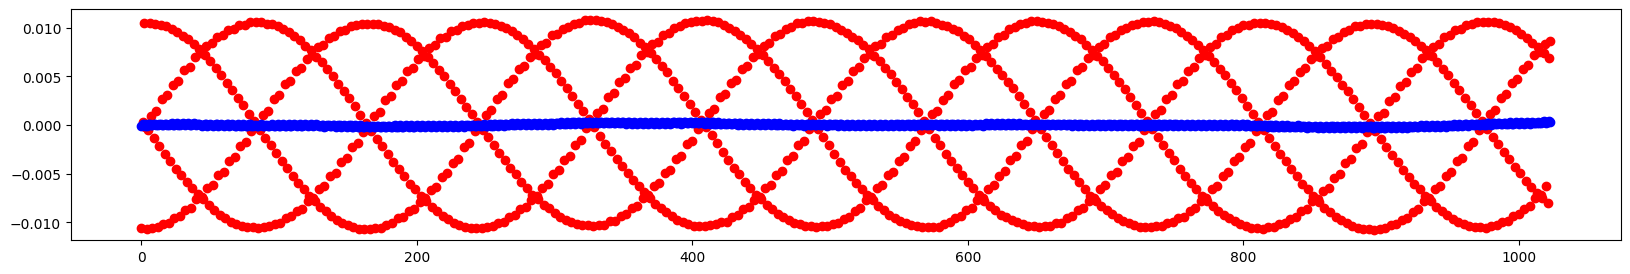

In [6]:
# Estimate parameters for signal with noise

# Set parameters

length = 8192

# Set signal

t = torch.linspace(0, length - 1, length, dtype=dtype, device=device)
f = 0.123456789
x = 1.0*torch.cos(0.25 + 2.0*numpy.pi*f*t) + 0.01*torch.cos(0.5 + 2.0*numpy.pi*2*f*t)
x.add_(0.001*torch.randn(length, dtype=dtype, device=device))
x = torch.stack([x])

# Set shift size for starting position

shift = 1

# Set window
# Note, without noise window increases convergence
# With noise window amplifies noise and should be use with care if noise is large
# A possible option is to filter data or to use fractional window order

w1 = Window.from_cosine(128, 0.0, dtype=dtype, device=device)
w2 = Window.from_cosine(128, 0.5, dtype=dtype, device=device)

# Estimate amplitude and phase using shifted samples of length 128
# Note, noise is correlated

A1, B1 = [], []
A2, B2 = [], []
for step in range(limit):
    y = x[:, step*shift: step*shift + 128]
    param, _ = Decomposition.harmonic_sum(f, w1.window, y)
    *_, a, b = param.T
    A1.append(a)
    B1.append(b)
    param, _ = Decomposition.harmonic_sum(f, w2.window, y)
    *_, a, b = param.T
    A2.append(a)
    B2.append(b)

# Format result (amplitude is constant, while phase is shifted)

A1 = torch.stack(A1).flatten()
B1 = torch.stack(B1).flatten()
B1 = mod(B1 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)
A2 = torch.stack(A2).flatten()
B2 = torch.stack(B2).flatten()
B2 = mod(B2 - 2.0*numpy.pi*f*shift*torch.linspace(0, limit - 1, limit, dtype=dtype, device=device), 2.0*numpy.pi, -numpy.pi)

# Compare mean values over samples

print(f'w1: {torch.abs(A1.mean() - 1.0):12.9} {torch.abs(B1.mean() - 0.25):12.9}')
print(f'w2: {torch.abs(A2.mean() - 1.0):12.9} {torch.abs(B2.mean() - 0.25):12.9}')

# Plot estimations for each sample

plt.figure(figsize=(20, 3))
plt.scatter(range(limit), (A1 - 1.00).cpu().numpy(), c='red')
plt.scatter(range(limit), (A2 - 1.00).cpu().numpy(), c='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.scatter(range(limit), (B1 - 0.25).cpu().numpy(), c='red')
plt.scatter(range(limit), (B2 - 0.25).cpu().numpy(), c='blue')
plt.show()

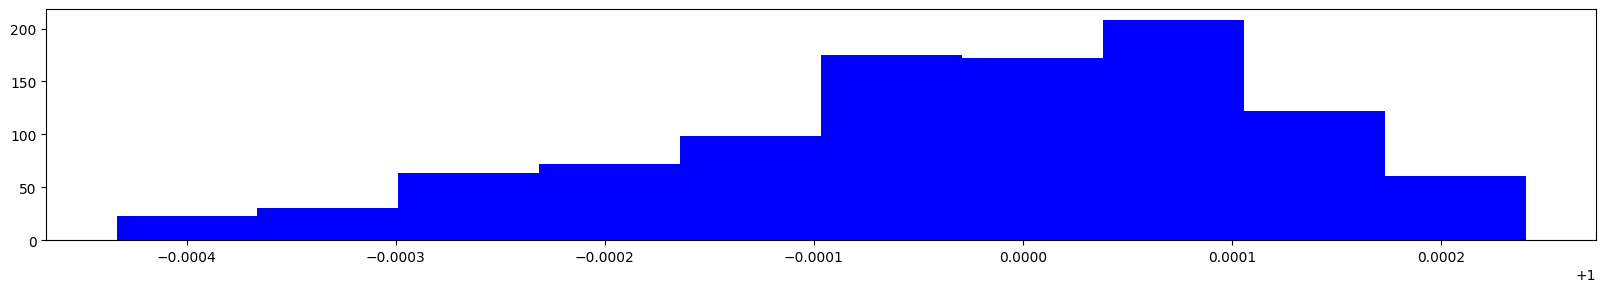

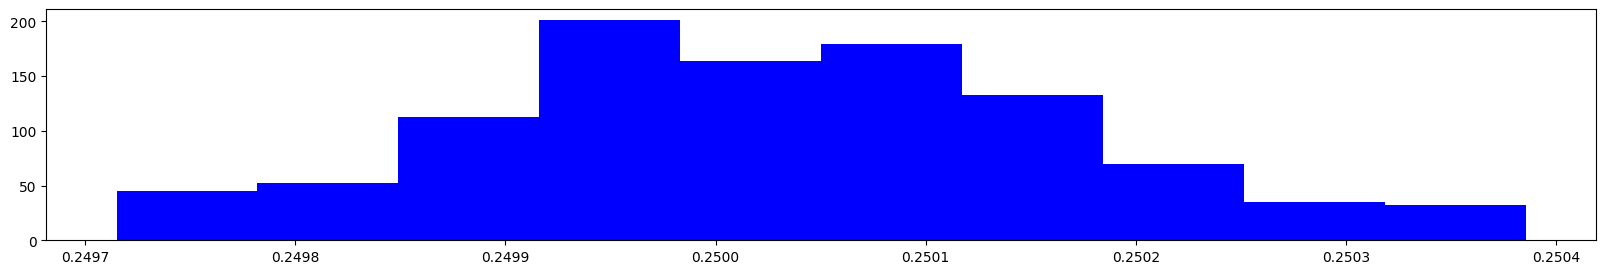

In [7]:
# Plot histogram

plt.figure(figsize=(20, 3))
plt.hist(A2.cpu().numpy(), color='blue')
plt.show()

plt.figure(figsize=(20, 3))
plt.hist(B2.cpu().numpy(), color='blue')
plt.show()

# Other cases have similar histograms
# Note, distribution looks somewhat not normal

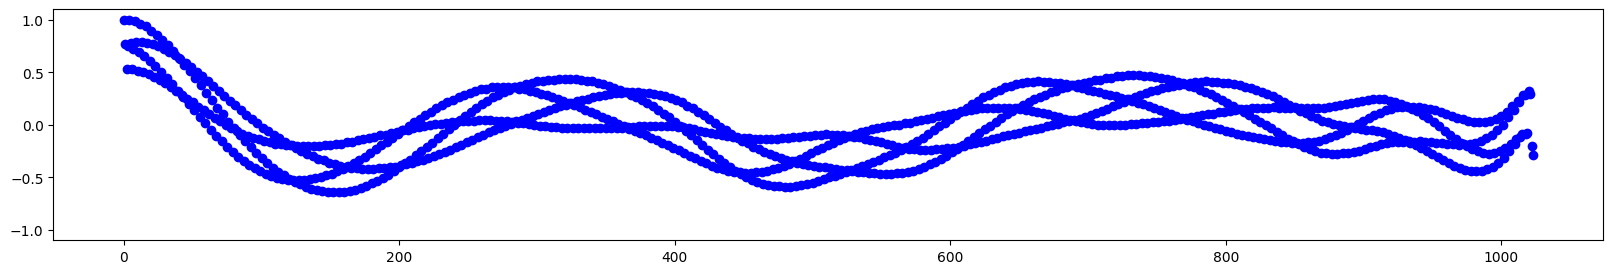

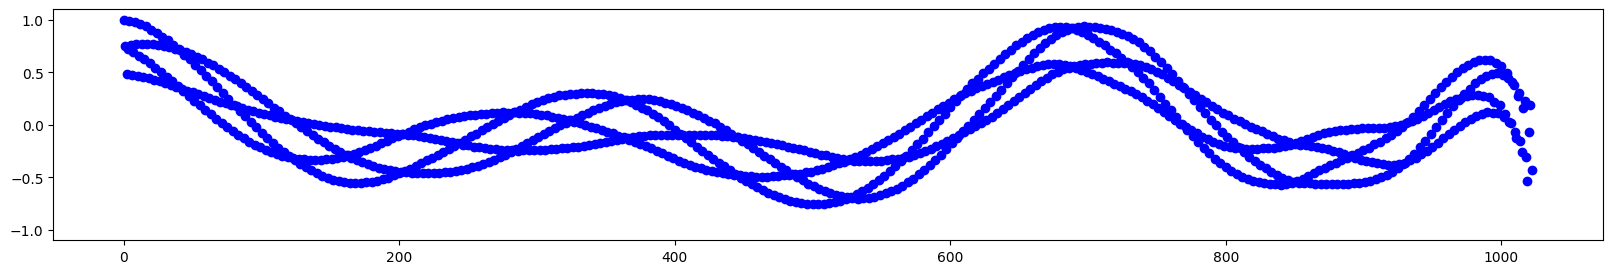

In [8]:
# Plot autocorrelation of estimations

AC = Frequency.autocorrelation(torch.stack([A2-A2.mean()])).flatten().cpu().numpy()
plt.figure(figsize=(20, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

AC = Frequency.autocorrelation(torch.stack([B2-B2.mean()])).flatten().cpu().numpy()
plt.figure(figsize=(20, 3))
plt.scatter(range(limit), AC, color='blue')
plt.ylim(-1.1, +1.1)
plt.show()

# Example-04: Amplitude estimation

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# In this example amplitude estimation loop is described
# Amplitude and its error is estimated for given frequency using different methods

frequency= 0.536883099, spread=1.37250775e-16, error=2.56151871e-13


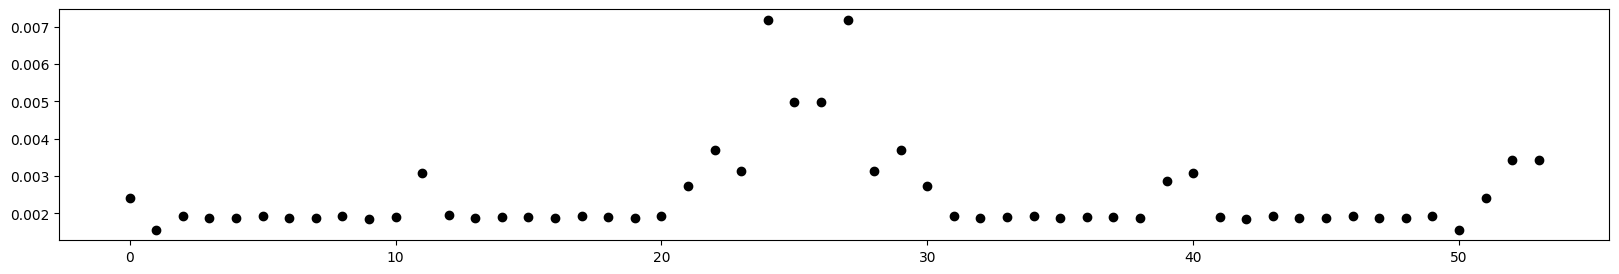

In [4]:
# Estimate reference parameters

# Set window

length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency

h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error

result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a=a, b=b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

# Plot amplitude

plt.figure(figsize=(20, 3))
plt.scatter(range(54), amplitude.cpu(), color='black')
plt.show()

In [5]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 256 for amplitude

# Set window

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise

n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883032, spread=1.11278246e-06


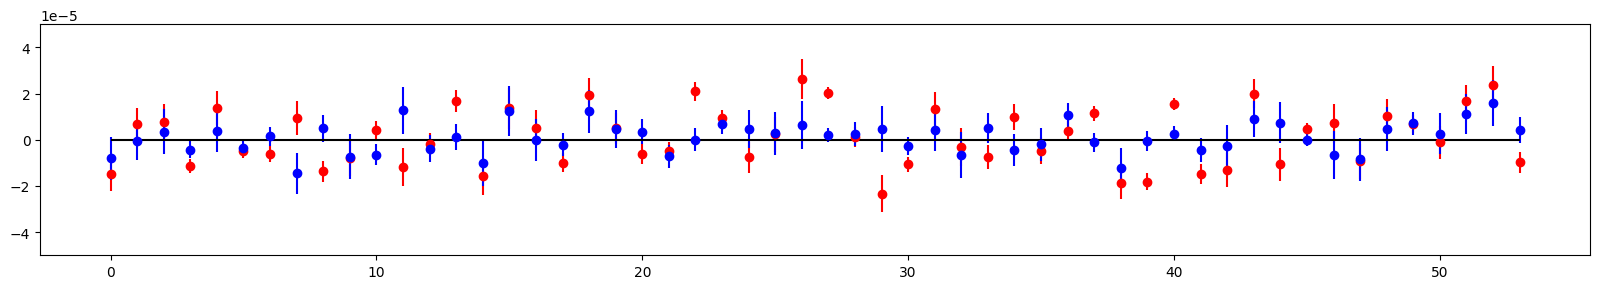

tensor(5.873034807954e-04, dtype=torch.float64)
tensor(2.946756360807e-04, dtype=torch.float64)


In [6]:
# Amplitude (and its error) can be estimated using harmonic_amplitude method

dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation without window (noise is estimated using optimal SVD truncation)

out1, err1, _ = dec.harmonic_amplitude(frequency, length=256, order=0.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread using error propogation with window
# Note, fractional window order can be used too, e.g. 0.5

out2, err2, _ = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

print((out1 - amplitude).abs().sum())
print((out2 - amplitude).abs().sum())

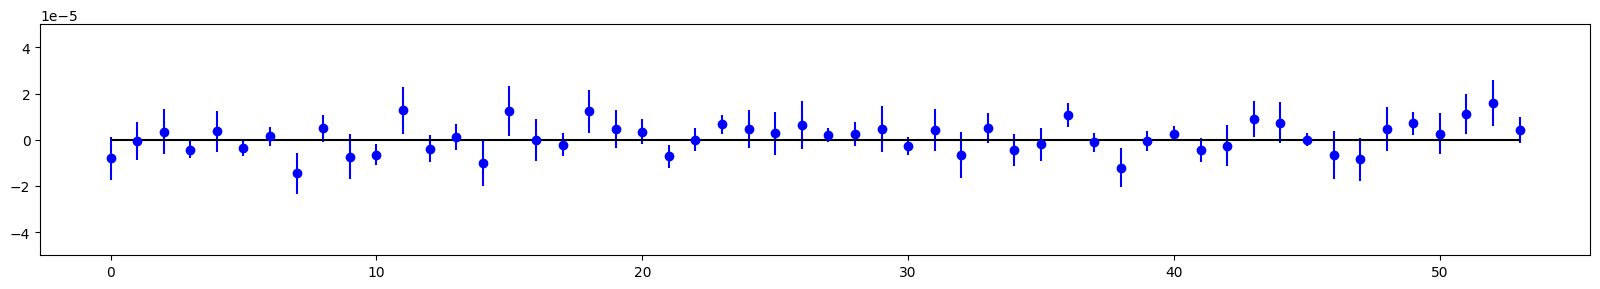

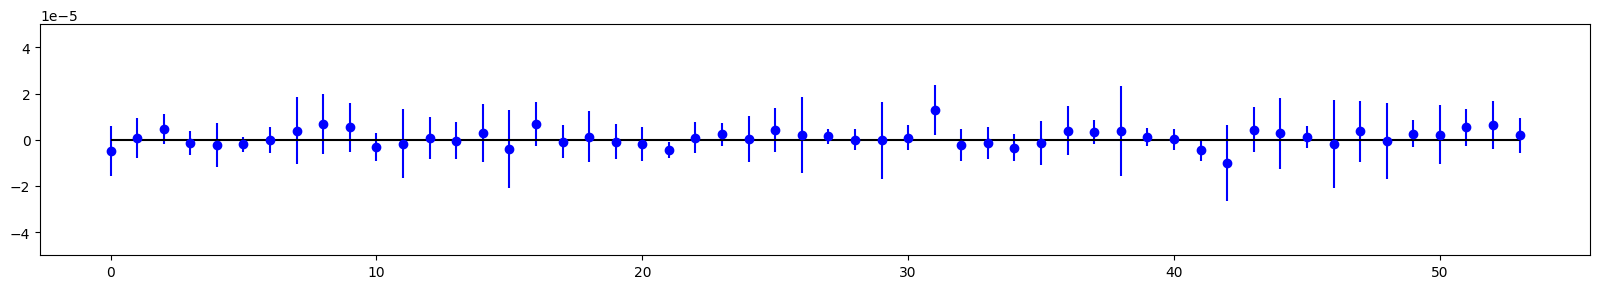

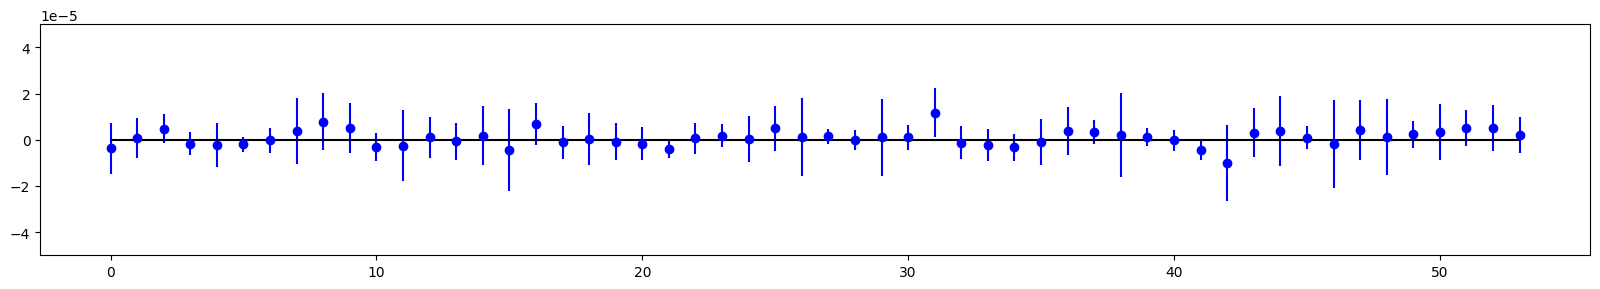

tensor(2.946756360807e-04, dtype=torch.float64)
tensor(1.556087787642e-04, dtype=torch.float64)
tensor(1.501409733753e-04, dtype=torch.float64)


In [7]:
# Sampling can be used to improve estimation accuracy (sampling reduce effect of bias)

dec = Decomposition(d)

# Estimate amplitude and its spread using error propogation

out1, err1, _ = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)

# Estimate amplitude and its spread from shifted samples
out2, err2, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, method='none')
out3, err3, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, method='noise')

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

print((out1 - amplitude).abs().sum())
print((out2 - amplitude).abs().sum())
print((out3 - amplitude).abs().sum())

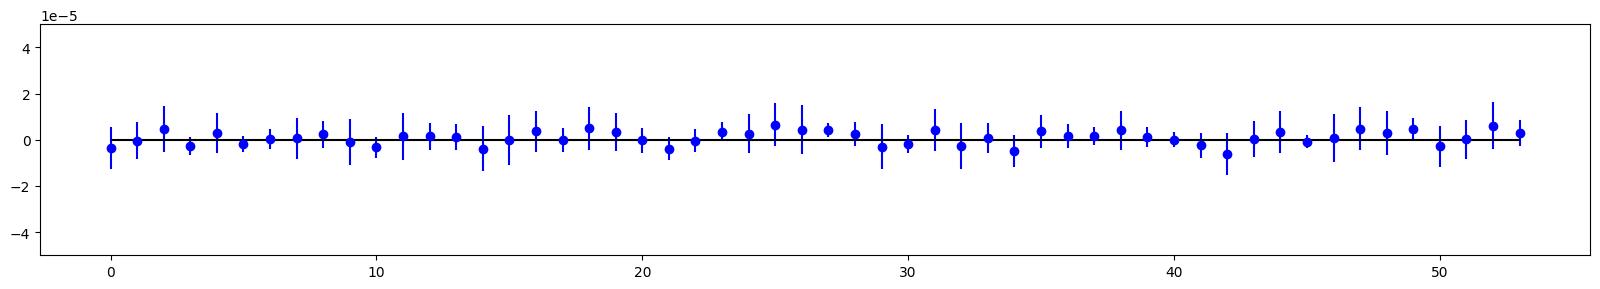

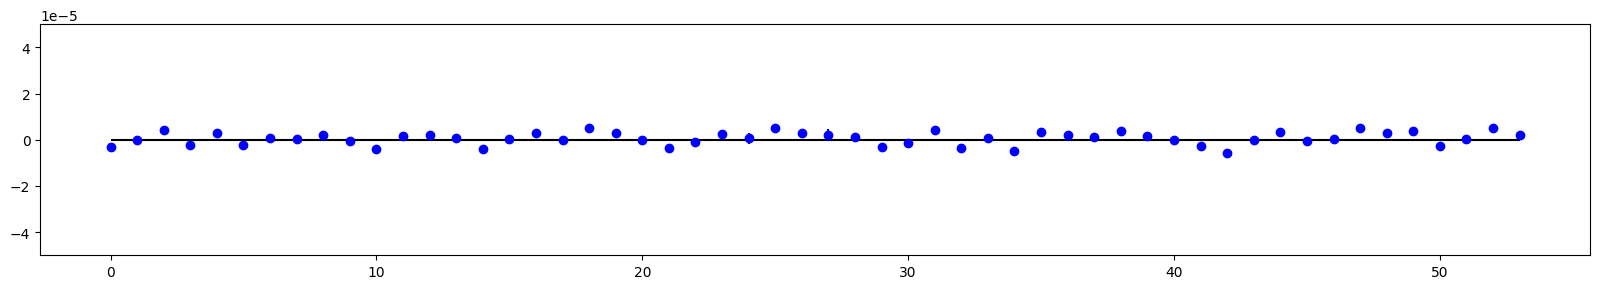

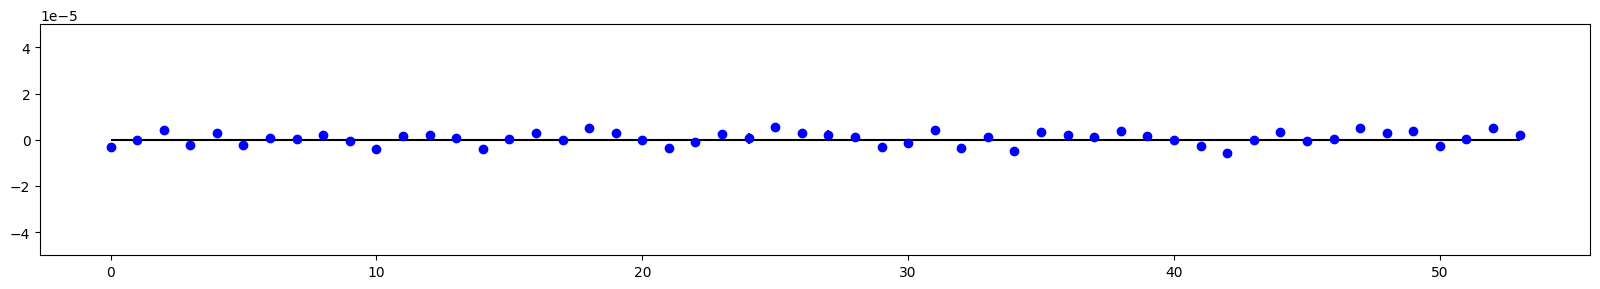

tensor(1.392229778278e-04, dtype=torch.float64)
tensor(1.247371801433e-04, dtype=torch.float64)
tensor(1.246479567945e-04, dtype=torch.float64)


In [8]:
# Filter data (full avaliable length is used)

flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# Estimate amplitude

dec = Decomposition(d)
out1, err1, _ = dec.harmonic_amplitude(frequency, length=256, order=1.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, method='none')
out3, err3, _ = dec.harmonic_amplitude(frequency, length=128, order=1.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, method='noise')

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out1-amplitude).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out2-amplitude).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out3-amplitude).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

print((out1 - amplitude).abs().sum())
print((out2 - amplitude).abs().sum())
print((out3 - amplitude).abs().sum())

d.reset()

# Note, with filtering, error estimations from sampled signals might be underestimated depending on window order

# Example-05: Phase estimation

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

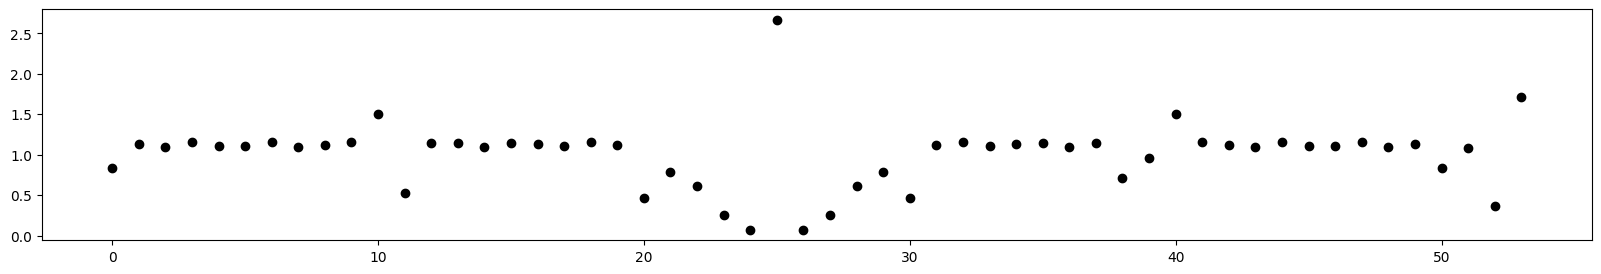

In [3]:
# Load model phase advance data

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}

total = config['TAIL']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=dtype, device=device)

# Plot adjacent phase advance

model, _ = Decomposition.phase_adjacent(total, model)
plt.figure(figsize=(20, 3))
plt.scatter(range(54), model.cpu().numpy(), color='black')
plt.show()

In [4]:
# Estimate reference parameters

# Set window

length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency

h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error

result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a=a, b=b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.37250775e-16, error=2.56151871e-13


In [5]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise

n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883013, spread=1.1499505e-06


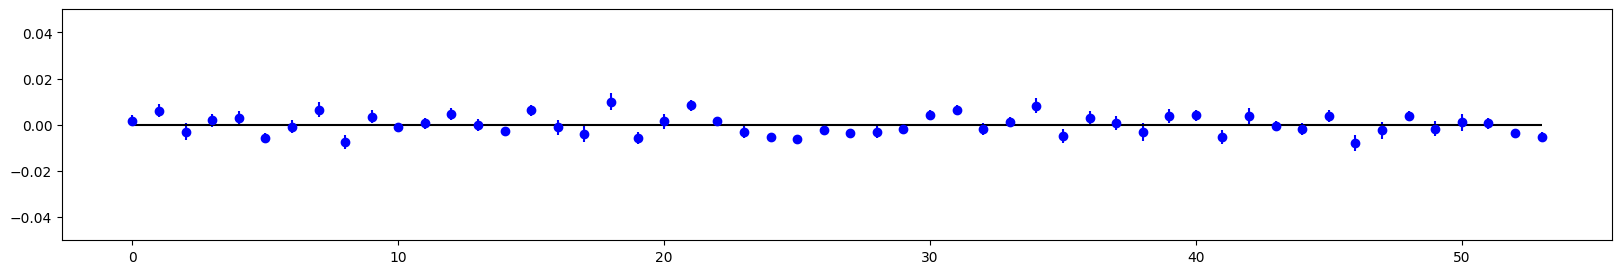

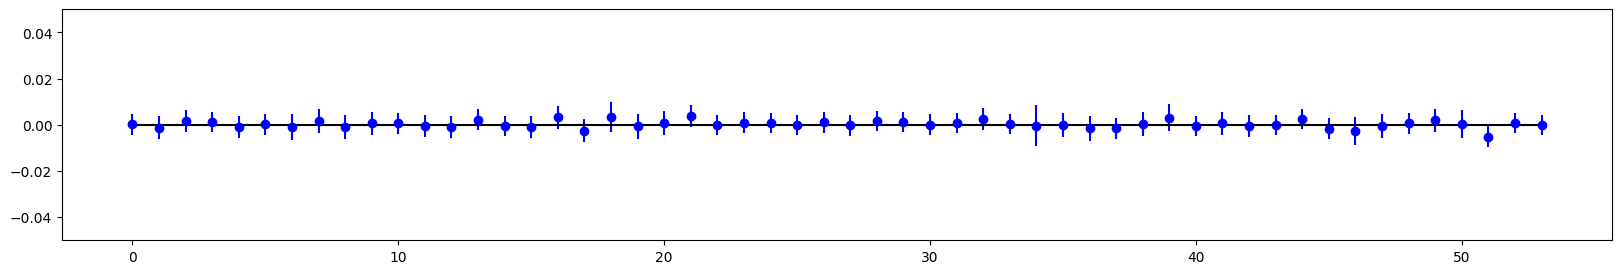

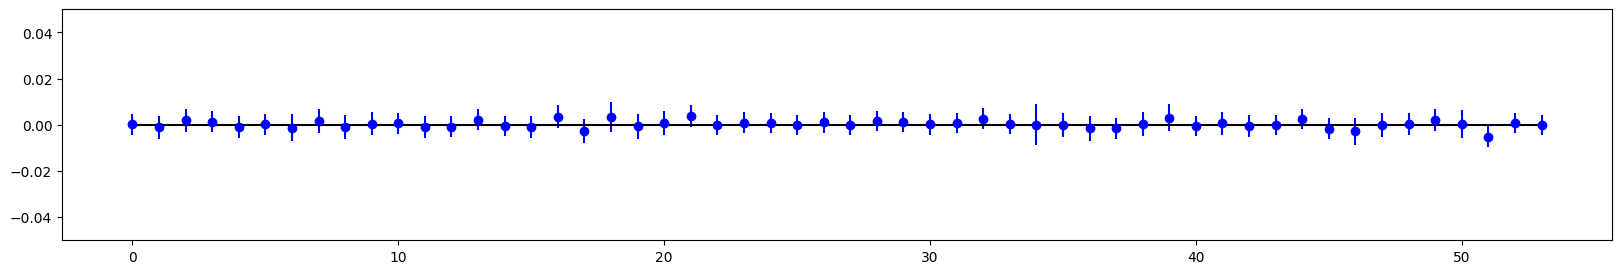

tensor(1.964897889357e-01, dtype=torch.float64)
tensor(6.468313110960e-02, dtype=torch.float64)
tensor(6.479449715026e-02, dtype=torch.float64)


In [6]:
# Estimate phase

dec = Decomposition(d)
out1, err1, _ = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, clean=False, method='none')
out3, err3, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, clean=False, method='noise')

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

print((out1 - phase).abs().sum())
print((out2 - phase).abs().sum())
print((out3 - phase).abs().sum())

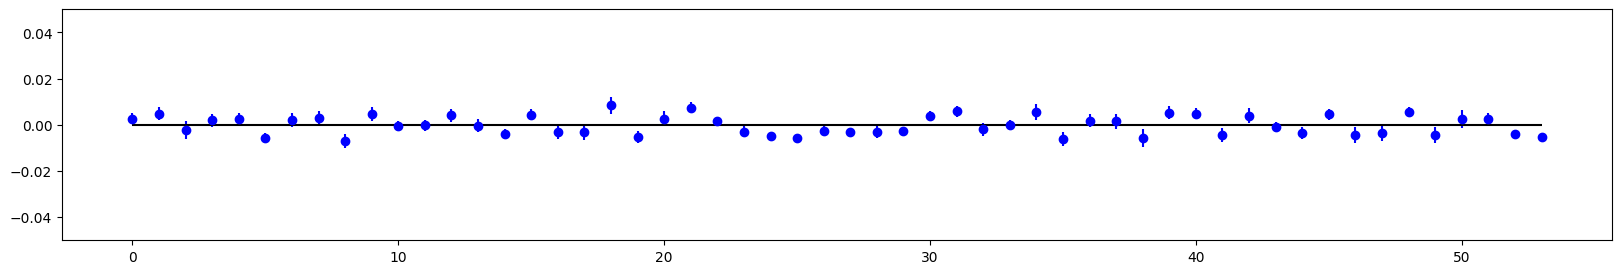

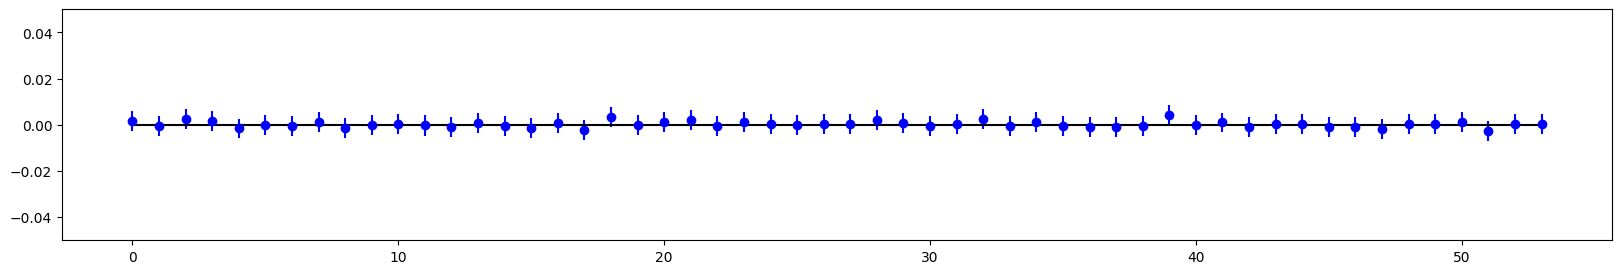

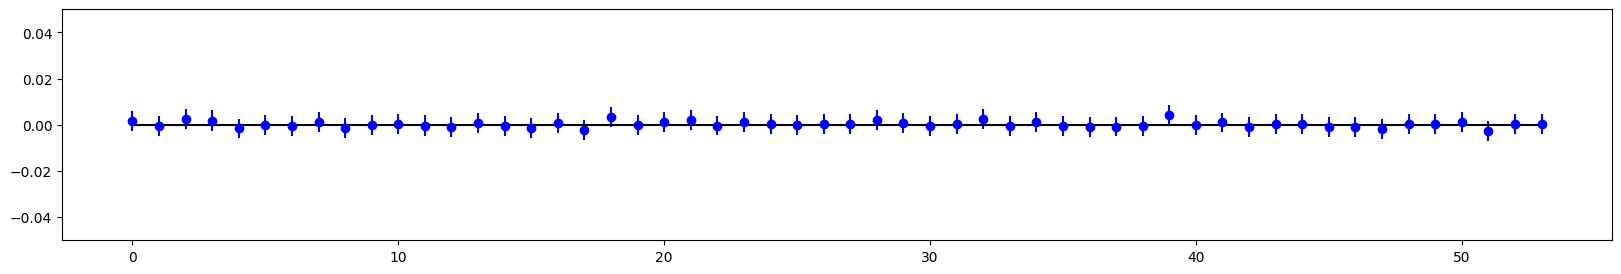

tensor(1.992010788797e-01, dtype=torch.float64)
tensor(5.587386483783e-02, dtype=torch.float64)
tensor(5.603022061181e-02, dtype=torch.float64)


In [7]:
# Estimate phase (filter)

flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)
out1, err1, _ = dec.harmonic_phase(frequency, length=512, order=0.0, error=True, sigma_frequency=spread)
out2, err2, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, clean=False, method='none')
out3, err3, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, clean=False, method='noise')

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out1 - phase).cpu().numpy(), yerr=err1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out2 - phase).cpu().numpy(), yerr=err2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (out3 - phase).cpu().numpy(), yerr=err3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

print((out1 - phase).abs().sum())
print((out2 - phase).abs().sum())
print((out3 - phase).abs().sum())

d.reset()

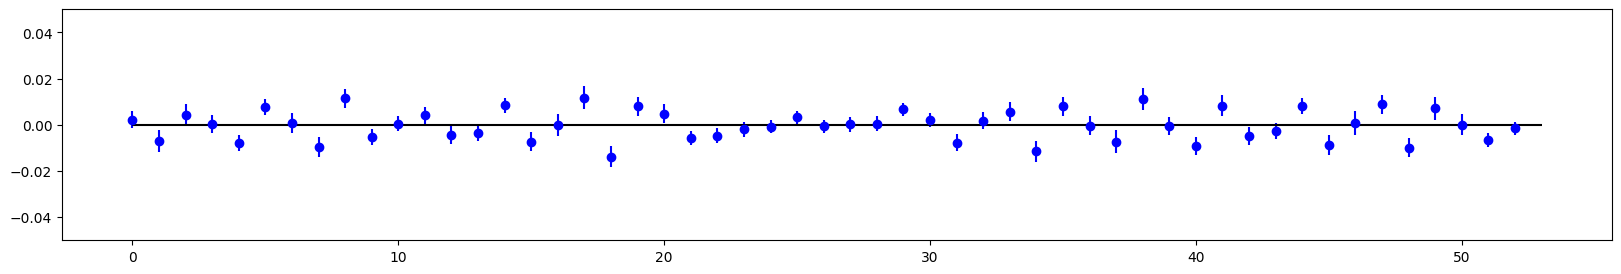

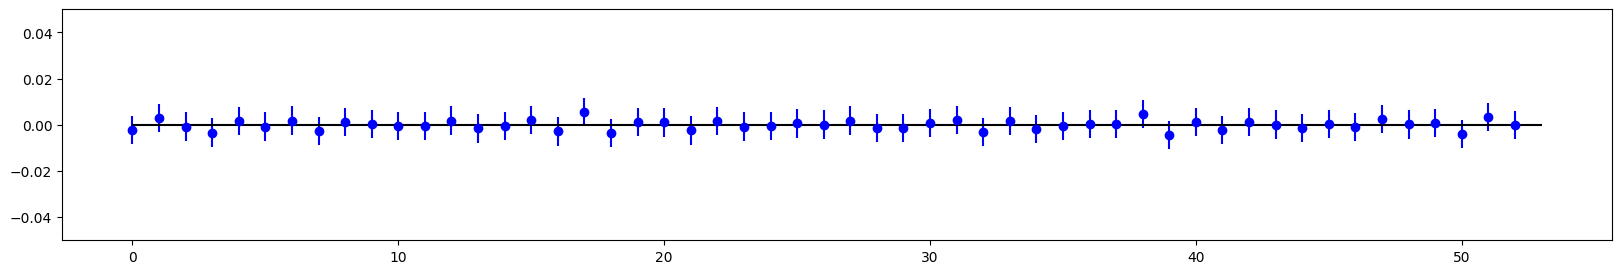

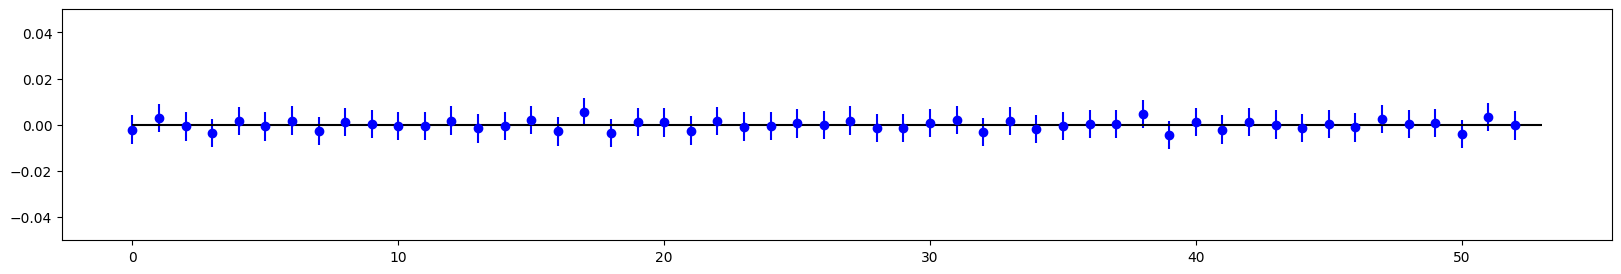

tensor(9.123930520356e-01, dtype=torch.float64)
tensor(7.268877958956e-01, dtype=torch.float64)
tensor(7.270459094813e-01, dtype=torch.float64)


In [8]:
# Compute and compare phase advance for the last case

add1, std1 = Decomposition.phase_adjacent(frequency, out1, error=True, sigma_frequency=spread, sigma_phase=err1)
add2, std2 = Decomposition.phase_adjacent(frequency, out2, error=True, sigma_frequency=spread, sigma_phase=err2)
add3, std3 = Decomposition.phase_adjacent(frequency, out3, error=True, sigma_frequency=spread, sigma_phase=err3)

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (add1 - model).cpu().numpy(), yerr=std1.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (add2 - model).cpu().numpy(), yerr=std2.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (add3 - model).cpu().numpy(), yerr=std3.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

print((add1 - model).abs().sum())
print((add2 - model).abs().sum())
print((add3 - model).abs().sum())

In [9]:
# Compute phase advance using SVD

u, s, vh = torch.linalg.svd(d.data, full_matrices=False)
out4 = torch.atan2(s[1]*u[:, 1], s[0]*u[:, 0])
add4, _ =  Decomposition.phase_adjacent(frequency, out4, error=False)
print((add4 - model).abs().sum())

add4 = Decomposition.svd_advance(frequency, d.data)
print((add4 - model).abs().sum())

tensor(7.731425955760e-01, dtype=torch.float64)
tensor(7.731425955760e-01, dtype=torch.float64)


In [10]:
# Compute phase advance using ICA
# Note, order of components is not guarantied, use model to infere order

from sklearn.decomposition import FastICA
ica = FastICA(n_components=2, whiten='unit-variance')
_ = ica.fit_transform(d.data.T)
out5 = torch.tensor(ica.mixing_, dtype=dtype, device=device).T
out5 = torch.atan2(out5[0], out5[1])
add5, _ = Decomposition.phase_adjacent(frequency, out5, error=False)
print((add5 - model).abs().sum())

add5 = Decomposition.ica_advance(frequency, d.data, model, whiten='unit-variance')
print((add5 - model).abs().sum())

tensor(7.731533089149e-01, dtype=torch.float64)
tensor(7.731533089149e-01, dtype=torch.float64)


# Example-06: Synchronization check & phase correction

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# In this example synchonization error (wrong starting turn) and corresponding phase correction is presented
# Separate function is available in Twiss class

In [4]:
# Load phase advance data

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}
advance = numpy.array([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR' or key == 'TAIL'])
advance = numpy.diff(advance)
advance = torch.tensor(advance, dtype=dtype, device=device)

In [5]:
# Set window

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data

table = numpy.load('../virtual_tbt.npy')

# Set correct starting position for all signals

start = 128

# Set synchronization errors
# If shifted in + by one, need to - for correction
# If shifted in - by one, need to + for correction

error = {10: 127, 31: 129, 32:129, 41:127, 43:129}

# Set data

d = torch.zeros((54, length), dtype=dtype, device=device)
for i in range(54):
    first = start if i not in error else error[i]
    d[i] = torch.tensor(table[i, first: first + length])
d = Data.from_data(w, d)

# Add random noise

n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883116, spread=1.42096061e-06


8.536883116127028
12.536883116127026


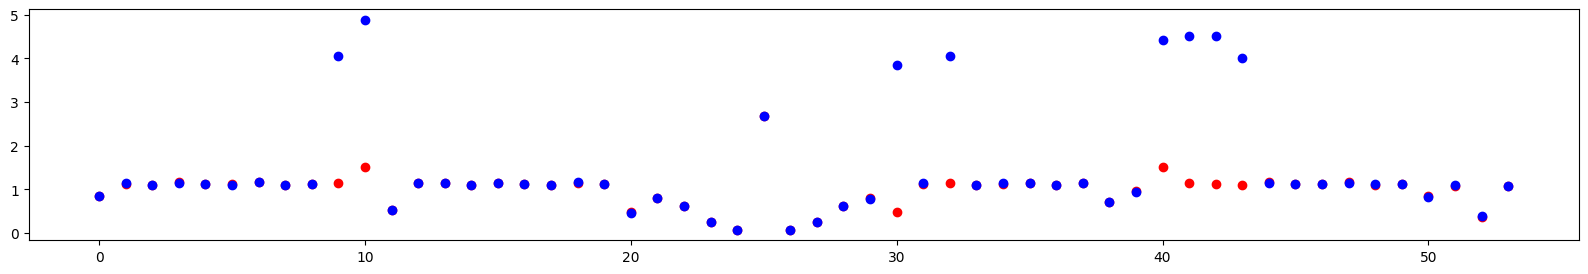

In [6]:
# Estimate phase and compute phase advance

dec = Decomposition(d)
out, _, _ = dec.harmonic_phase(frequency, length=512, order=0.0)
add, _ = Decomposition.phase_adjacent(frequency, out)

# Total advance might be used as indicator in some cases (not robust)

print((8.0 + frequency).item())
print((add.sum()/(2.0*numpy.pi)).item())

# Plot phase advance

plt.figure(figsize=(20, 3))
plt.scatter(range(54), advance.cpu().numpy(), color='red')
plt.scatter(range(54), add.cpu().numpy(), color='blue')
plt.show()

In [7]:
# To perform a more robust test & correction, the following is assumed:

# A) most of signals have no synchronization error
# B) signal can be off only by one turn in any direction
# C) without synchronization errors phase advance is close to model (some threshold can be specified)

# With these assumptions, it is possible to identify signals that might have a synchronization error
# To do this, pairs with large advance error are marked (based on robust dispersion or other methods, see below)
# Other pairs are assumed to be correct
# Signals at the endpoints are correct
# Select adjacent signal with correct phase and right marked signal, check the effect of adding or subtracting of one turn
# If such correction results in significant improvement, change corresponding phase (starting position might not be avalible)
# Do this for all marked signals

# If synchronization error is indeed present, results should match for both planes

# Ones corrected, tests can be performed again (e.g. when not all pairs are marked initialy)

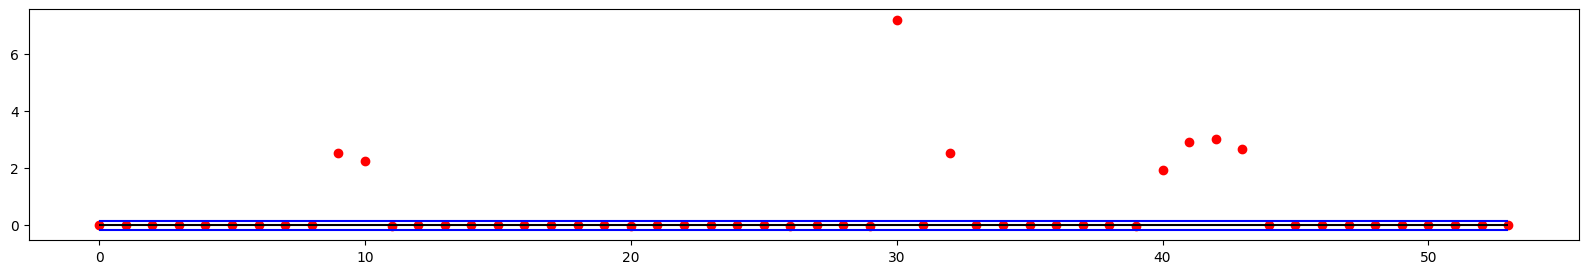

In [8]:
# Plot difference from the model model

delta = (add-advance)/advance

q25 = torch.quantile(delta, 0.25).cpu().numpy()
q50 = torch.quantile(delta, 0.50).cpu().numpy()
q75 = torch.quantile(delta, 0.75).cpu().numpy()

l, u = q25 - 10.0*(q75 - q25), q75 + 10.0*(q75 - q25)

plt.figure(figsize=(20, 3))
plt.scatter(range(54), delta.cpu().numpy(), color='red')
plt.hlines(q50, 0, 53, colors='black')
plt.hlines(l, 0, 53, colors='blue')
plt.hlines(u, 0, 53, colors='blue')
plt.show()

In [9]:
# LOF

from sklearn.neighbors import LocalOutlierFactor
detector = LocalOutlierFactor(contamination=0.05)
pairs = detector.fit_predict(delta.reshape(-1, 1).cpu().numpy())
pairs, *_ = numpy.in1d(delta.cpu().numpy(), delta[pairs == -1].cpu().numpy()).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[30, 31], [41, 42], [42, 43]]


In [10]:
# IFO

from sklearn.ensemble import IsolationForest
detector = IsolationForest(contamination=0.05)
pairs = detector.fit_predict(delta.reshape(-1, 1).cpu().numpy())
pairs, *_ = numpy.in1d(delta.cpu().numpy(), delta[pairs == -1].cpu().numpy()).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[30, 31], [40, 41], [42, 43]]


In [11]:
# DBSCAN

from sklearn.cluster import DBSCAN
from collections import Counter
cluster = DBSCAN().fit(delta.reshape(-1, 1).cpu().numpy())
label, *_ = Counter(cluster.labels_)
pairs, *_ = numpy.in1d(delta.cpu().numpy(), delta[cluster.labels_ != label].cpu().numpy()).nonzero()
pairs = [[i, i + 1] for i in tuple(pairs)]
print(pairs)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [12]:
# Pairs outside acceptance region

l_p, *_ = numpy.where(delta.cpu().numpy() < l)
u_p, *_ = numpy.where(delta.cpu().numpy() > u)
marked = (*tuple(l_p), *tuple(u_p))
marked = [[i, i + 1] for i in marked]
print(marked)

[[9, 10], [10, 11], [30, 31], [32, 33], [40, 41], [41, 42], [42, 43], [43, 44]]


In [13]:
# Marked signals

table = []
chain = []
for i in numpy.unique(numpy.array(pairs).flatten()):
    if chain == []:
        chain.append(i)
        value = i
        continue
    if i == value + 1:
        chain.append(i)
        value = i
        continue
    table.append(chain)
    chain = []
    chain.append(i)
    value = i
else:
    table.append(chain)
print(table)
    
# Remove endpoints

table = [*map(lambda x: x[1:-1], table)]
print(table)

# Set marked and passed

marked = [j for i in table for j in i]
passed = [i for i in range(54) if i not in marked]

# Set phase

phase = torch.clone(out)

# Correct

for i in marked:
    phase_x = phase[i-1]
    phase_y = phase[i]
    phase_y = phase_y + torch.stack([-2.0*numpy.pi*frequency, 0.0*numpy.pi*frequency, +2.0*numpy.pi*frequency])
    phase_y = mod(phase_y, 2*numpy.pi, -numpy.pi)
    delta = mod(phase_y - phase_x, 2*numpy.pi)
    delta = torch.abs(delta - advance[i-1])
    index = delta.argmin().item()
    print(f"{i}: {['+', ' ', '-'][index]}, {128 + [+1, 0, -1][index]}")
    phase[i] = phase_y[index]
    
print(error)

[[9, 10, 11], [30, 31, 32, 33], [40, 41, 42, 43, 44]]
[[10], [31, 32], [41, 42, 43]]
10: -, 127
31: +, 129
32: +, 129
41: -, 127
42:  , 128
43: +, 129
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}


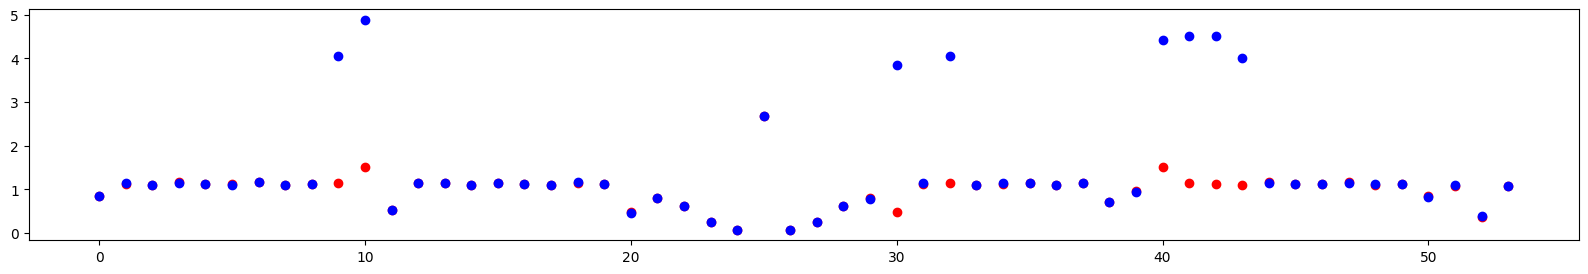

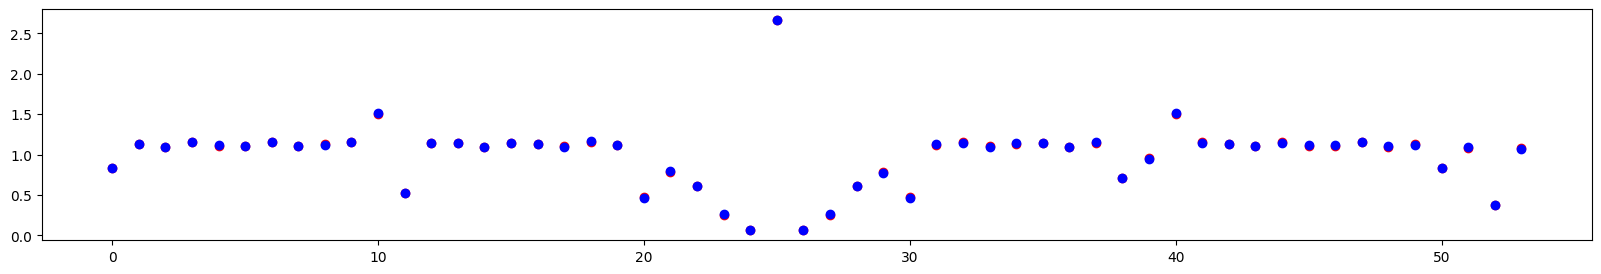

In [14]:
# Plot advance using corrected phase

plt.figure(figsize=(20, 3))
plt.scatter(range(54), advance.cpu().numpy(), color='red')
plt.scatter(range(54), add.cpu().numpy(), color='blue')
plt.show()

correct, _ = Decomposition.phase_adjacent(frequency, phase)
plt.figure(figsize=(20, 3))
plt.scatter(range(54), advance.cpu().numpy(), color='red')
plt.scatter(range(54), correct.cpu().numpy(), color='blue')
plt.show()

{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}
{10: 127, 31: 129, 32: 129, 41: 127, 43: 129}


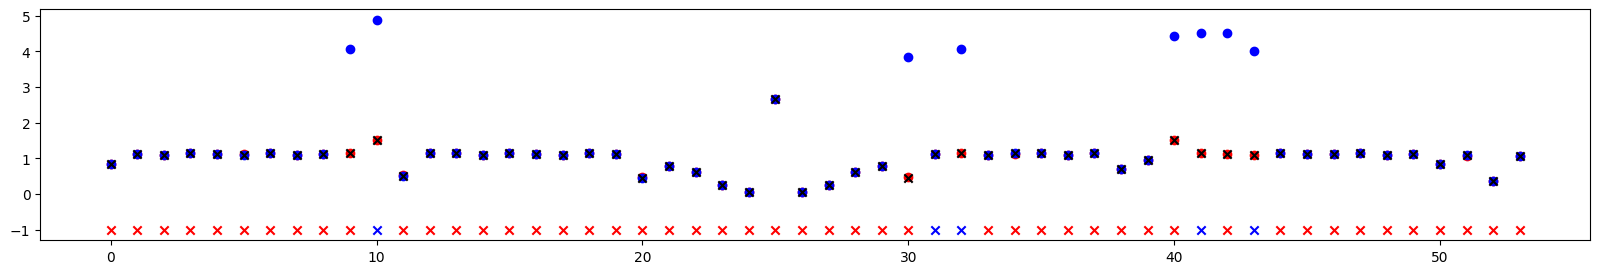

In [15]:
# phase_check classmethod can be used to perform shyncronization test
# robust spread is used to flag outliers

print(error)

q = frequency.item()
phase = out

Q = config['TAIL']['FX']/(2.0*numpy.pi)
PHASE = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=dtype, device=device)

result, select = Decomposition.phase_check(q, Q, phase, PHASE)
result = {key: value[0] + start for key, value in result.items() if value[0] != 0}
print(result)

plt.figure(figsize=(20, 3))
plt.scatter(range(54), select['model'].cpu().numpy(), color='red')
plt.scatter(range(54), select['phase'].cpu().numpy(), color='blue')
plt.scatter(range(54), select['check'].cpu().numpy(), color='black', marker='x')
plt.scatter(*numpy.array([[index, -1.0] for index in range(54) if index not in result]).T, color='red', marker='x')
plt.scatter(*numpy.array([[index, -1.0] for index in range(54) if index in result]).T, color='blue', marker='x')
plt.show()

# Example-07: Estimation of parameters with DHT

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Estimate reference parameters

# Set window

length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency

h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error

result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a=a, b=b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.37250775e-16, error=2.56151871e-13


In [4]:
# Real TbT data length is limited by decoherence

# Set window

length = 512
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise

n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536883457, spread=3.56983165e-06


In [5]:
# Filter data

flt = Filter(d)
flt.filter_svd(rank=2)
flt.filter_hankel(rank=2, random=True, buffer=16, count=16)

# DHT

dht = Frequency.dht(d.work)

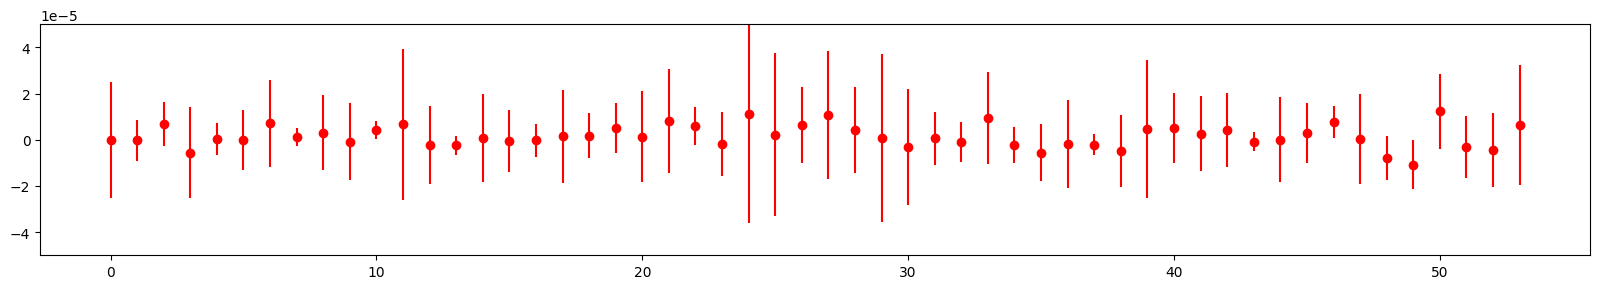

In [6]:
# Compute envelope

envelope = dht.abs()

# Estimate amplitude

endpoint = 16
estimate = envelope[:, +endpoint:-endpoint].mean(1)
spread = envelope[:, +endpoint:-endpoint].std(1)

# Compare

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (estimate - amplitude).cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.ylim(-5.0E-5, +5.0E-5)
plt.show()

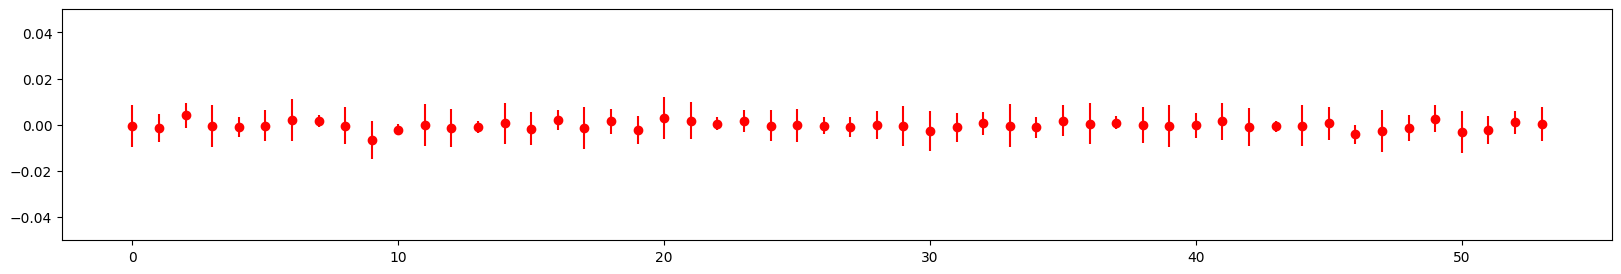

In [7]:
# Estimate phase

angle = dht.angle()
endpoint = 16
angle -= 2.0*numpy.pi*frequency*torch.linspace(0, length - 1, length, dtype=dtype, device=device)
angle = mod(angle, 2.0*numpy.pi, -numpy.pi)
estimate = angle[:, +endpoint:-endpoint].mean(1)
spread = angle[:, +endpoint:-endpoint].std(1)

# Compare

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (estimate - phase).cpu().numpy(), yerr=spread.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

# Example-08: Virtual phase

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# In this example phase is estimated for virtual locations
# Virtual locations are locations where TbT data is not avalible, e.g. fault BPMs or other locations of interest
# Locations where TbT data is avalible, i.e. phase can be computed from TbT data, are denoted as monitors
# Using measured phase at monitors and model phase advance data, phase at a virtual location can be computed
# It is also possible to treat a monitor location as a virtual location
# In this case, phase estimation accuracy can be improved in some cases

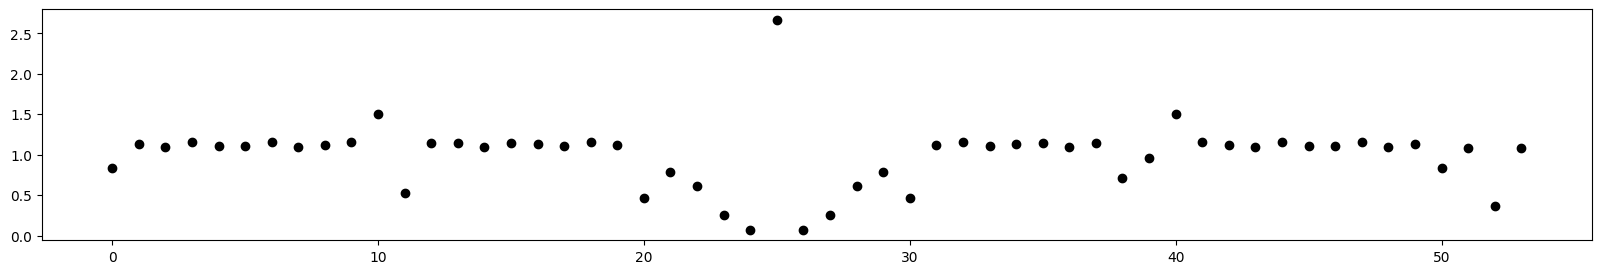

In [4]:
# Load model phase advance data
# Note, only monitor locations are selected, a subset of monitors will be demoted to virtual locations later
# Note, model phase advance error is given for each location (virtual or monitor), it corresponds to an error from given location to the next one

with open('../config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
    config = {key: config[key] for key in sorted(config.keys(), key=lambda name: config[name]['TIME'])}

total = config['TAIL']['FX']
model = torch.tensor([value['FX'] for key, value in config.items() if value['TYPE'] == 'MONITOR'], dtype=dtype, device=device)
error = 1.0E-4*torch.ones_like(model)

# Plot adjacent phase advance

model_advance, error_advance = Decomposition.phase_adjacent(total/(2.0*numpy.pi), model, error=True, sigma_frequency=None, sigma_phase=error, model=True)
plt.figure(figsize=(20, 3))
plt.errorbar(range(54), model_advance.cpu().numpy(), yerr=error_advance.cpu().numpy(), color='black', fmt=' ', marker='o')
plt.show()

In [5]:
# Estimate reference parameters

# Set window

length = 4096
w = Window(length, 'cosine_window', 5.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Estimate frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency

# Estimate amplitude for given frequency

h = Decomposition(d)
result, _ = h.harmonic_sum(frequency, w.window, d.data)
_, _, amplitude, phase = result.T

# Check maximum reconstruction error

result = []
for a, b in zip(amplitude, phase):
    result.append(Data.make_harmonic(length, frequency, a=a, b=b, dtype=dtype, device=device))
result = torch.stack(result)
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}, error={(d.data - result).abs().max().item():12.9}')

frequency= 0.536883099, spread=1.37250775e-16, error=2.56151871e-13


In [6]:
# Real TbT data length is limited by decoherence
# In this example 1024 turns are used for frequency estimation and only 512 for phase

# Set window

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)

# Load data

d = Data.from_file(54, w, '../virtual_tbt.npy')

# Add random noise

n = 1.0E-6*(25.0 + 75.0*torch.rand(54, dtype=dtype, device=device))
d.add_noise(n)
d.data.copy_(d.work)

# Estimate frequency (average over signals)

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
frequency, spread = f.frequency.mean(), f.frequency.std()
frequency = 1.0 - frequency
print(f'frequency={frequency.item():12.9}, spread={spread.item():12.9}')

frequency= 0.536882987, spread=1.08175016e-06


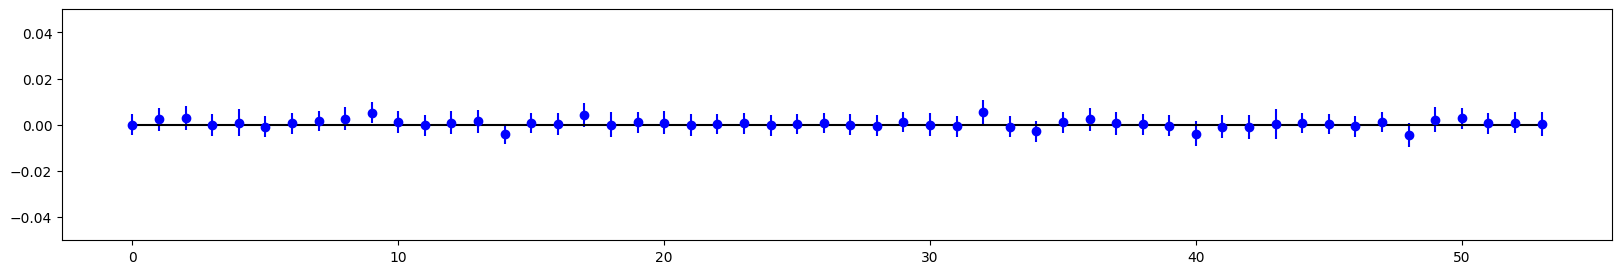

tensor(7.158183979246e-02, dtype=torch.float64)


In [7]:
# Estimate phase

dec = Decomposition(d)
phase_estimate, error_estimate, _ = dec.harmonic_phase(frequency, length=256, order=0.0, error=True, sigma_frequency=spread, shift=True, count=64, step=8, method='noise')

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (phase_estimate - phase).cpu().numpy(), yerr=error_estimate.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-5.0E-2, +5.0E-2)
plt.show()

print((phase_estimate - phase).abs().sum())

location=5
monitor: [error, sigma] = [0.0007919620725859722, 0.004459191166290336]
virtual: [error, sigma] = [0.0008398532098672917, 0.0018552050014745967]
location=25
monitor: [error, sigma] = [0.00032109025270016245, 0.004275564934877541]
virtual: [error, sigma] = [0.00041532819496686857, 0.001961477005011651]


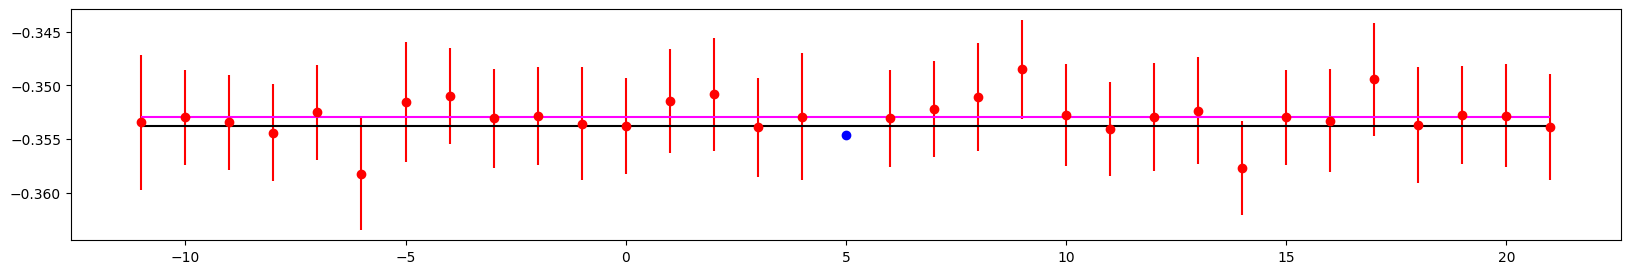

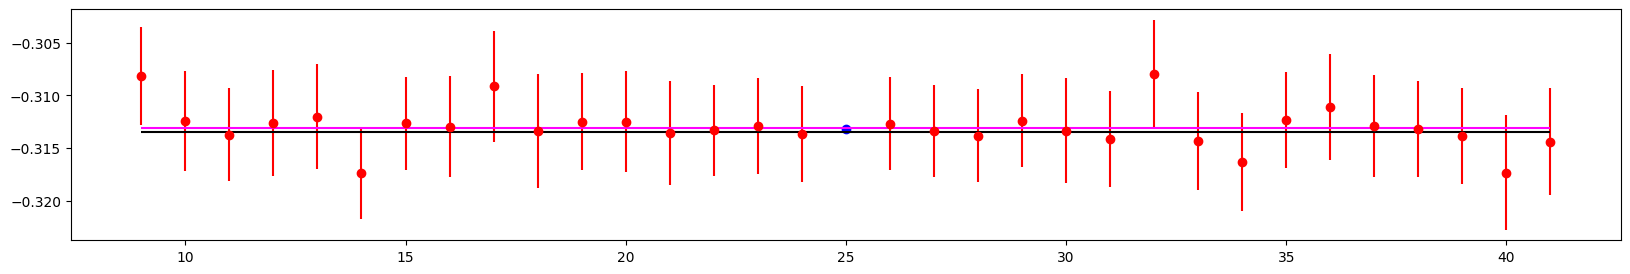

In [8]:
# Virtual phase

# Set demoted location
# Note, location index starts from zero

index = [5, 25]

# Set location flags, 0/1 for virtual/monitor locations

flags = torch.ones_like(model, dtype=torch.int64, device=device)
flags[index] = 0

# Set measured & model frequency with errors

q, sigma_q = frequency, spread
Q, sigma_Q = total/(2.0*numpy.pi), torch.sqrt(torch.sum(error**2))/(2.0*numpy.pi)

# Set measured phase with errors

phase_measured = torch.clone(phase_estimate)
error_measured = torch.clone(error_estimate)
phase_measured[index] = 0.0
error_measured[index] = 0.0

# Set model phase with error

phase_model = torch.clone(model)
error_model = torch.clone(error)

# Set range limit

limit = 16

# Estimate virtial phase for each virtual location

for location in index:
    
    result = dec.phase_virtual(location, limit, flags, q, Q, phase_measured, phase_model,
                               sigma_frequency=sigma_q, sigma_frequency_model=sigma_Q, 
                               sigma_phase=error_measured, sigma_phase_model=error_model,
                               full=True, clean=True)
    
    # Compare fit result with model
    
    print(f'{location=}')
    print(f'monitor: [error, sigma] = {[abs(phase[location] - phase_estimate[location]).item(), error_estimate[location].item()]}')
    print(f'virtual: [error, sigma] = {[abs(phase[location] - result["model"][0]).item(), result["model"][1].item()]}')
    
    #  Plot data for all locations
    
    plt.figure(figsize=(20, 3))
    plt.errorbar(list(result['index']), result['phase'].cpu().numpy(), yerr=result['error'].cpu().numpy(), color='red', fmt=' ', marker='o')
    plt.scatter(location, phase_estimate[location].cpu().numpy(), color='blue')
    plt.hlines(phase[location].cpu().numpy(), min(result['index'].keys()), max(result['index'].keys()), color='black')
    plt.hlines(result['model'][0].cpu().numpy(), min(result['index'].keys()), max(result['index'].keys()), color='magenta')

plt.show()
    
# red     -- estimation using different monitors 
# blue    -- estimation from TbT
# black   -- reference value
# magenta -- fitted value

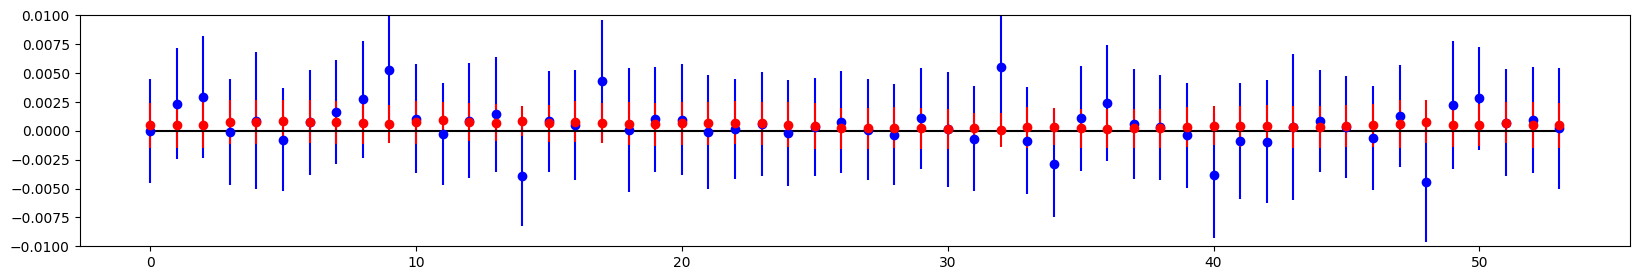

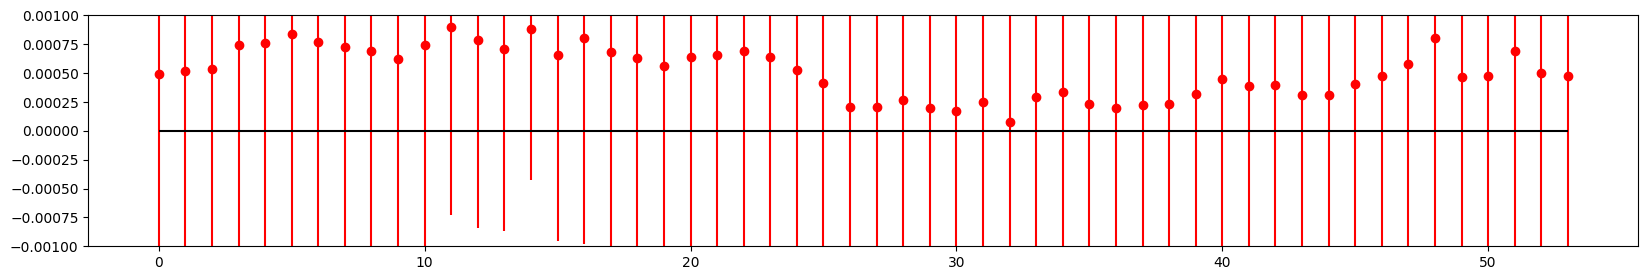

tensor(7.158183979246e-02, dtype=torch.float64)
tensor(2.755471294329e-02, dtype=torch.float64)


In [9]:
# Virtual phase for monitors

# Note, change limit value

# Set location flags, 0/1 for virtual/monitor locations

flags = torch.ones_like(model, dtype=torch.int32)

# Set measured & model frequency with errors

q, sigma_q = frequency, spread
Q, sigma_Q = total/(2.0*numpy.pi), torch.sqrt(torch.sum(error**2))/(2.0*numpy.pi)

# Set measured phase with errors

phase_measured = torch.clone(phase_estimate)
error_measured = torch.clone(error_estimate)

# Set model phase with error

phase_model = torch.clone(model)
error_model = torch.clone(error)

# Set range limit

limit = 16

# Estimate virtial phase for each virtual location

out = []
for location in range(len(flags)):
    
    result = dec.phase_virtual(location, limit, flags, q, Q, phase_measured, phase_model, 
                               sigma_frequency=sigma_q, sigma_frequency_model=sigma_Q, 
                               sigma_phase=error_measured, sigma_phase_model=error_model,
                               full=True, clean=True)
    
    out.append(result['model'])
    
phase_virtual, error_virtual = torch.stack(out).T

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (phase_estimate - phase).cpu().numpy(), yerr=error_estimate.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-3, +1.0E-3)
plt.show()

print((phase_estimate - phase).abs().sum())
print((phase_virtual - phase).abs().sum())

# Note, such 'correction' introduces bias, use with error estimates with care, adjust limit

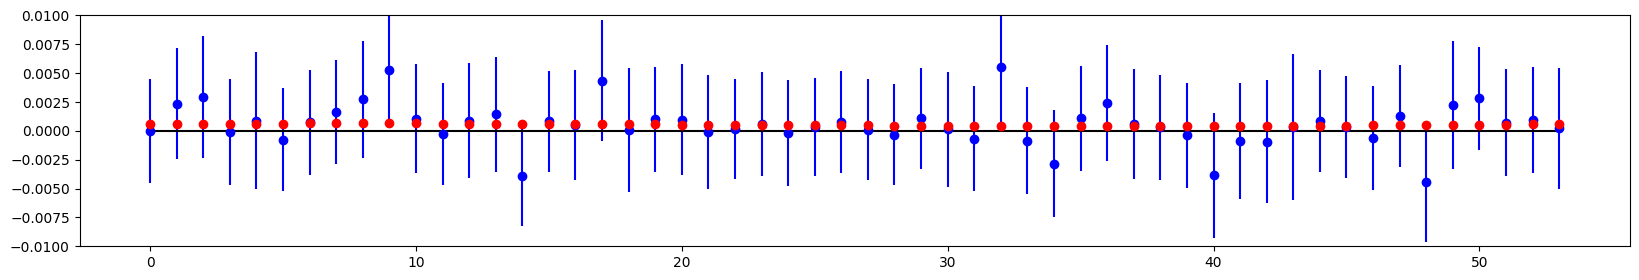

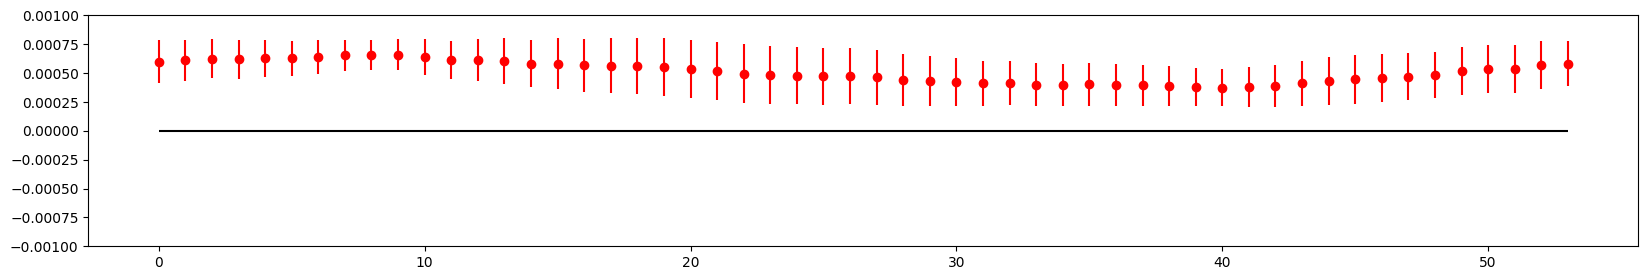

tensor(7.158183979246e-02, dtype=torch.float64)
tensor(2.753904603263e-02, dtype=torch.float64)


In [10]:
# Virtual phase for monitors (second pass)

# Note, second pass (or more) impoves std in general
# Note, change limit value

# Set location flags, 0/1 for virtual/monitor locations

flags = torch.ones_like(model, dtype=torch.int32)

# Set measured & model frequency with errors

q, sigma_q = frequency, spread
Q, sigma_Q = total/(2.0*numpy.pi), torch.sqrt(torch.sum(error**2))/(2.0*numpy.pi)

# Set measured phase with errors

phase_measured = torch.clone(phase_virtual)
error_measured = torch.clone(error_estimate)

# Set model phase with error

phase_model = torch.clone(model)
error_model = torch.clone(error)

# Set range limit

limit = limit

# Estimate virtial phase for each virtual location

out = []
for location in range(len(flags)):
    
    result = dec.phase_virtual(location, limit, flags, q, Q, phase_measured, phase_model, 
                               sigma_frequency=sigma_q, sigma_frequency_model=sigma_Q, 
                               sigma_phase=error_measured, sigma_phase_model=error_model,
                               full=True, clean=True)
    
    out.append(result['model'])
    
phase_virtual, error_virtual = torch.stack(out).T

# Compare results

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (phase_estimate - phase).cpu().numpy(), yerr=error_estimate.cpu().numpy(), fmt=' ', marker='o', color='blue')
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-2, +1.0E-2)
plt.show()

# Note, such 'correction' introduces bias, use with care, adjust limit

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), (phase_virtual - phase).cpu().numpy(), yerr=error_virtual.cpu().numpy(), fmt=' ', marker='o', color='red')
plt.hlines(0, 0, 53, colors='black')
plt.ylim(-1.0E-3, +1.0E-3)
plt.show()

print((phase_estimate - phase).abs().sum())
print((phase_virtual - phase).abs().sum())

# Example-09: Prony decomposition

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Prony decomposition can be used to estimate signal parameters from data
# Signal model is a sum of complex components
# s(t) = ... + a_i*exp(2*pi*b_i*t) + ... with complex parameters a_i & b_i

In [4]:
# Define test signal with four complex components (two real components)

time  = torch.linspace(0, 1024 - 1, 1024, dtype=dtype, device=device)

signal  = torch.zeros_like(time)
signal += 0.5*torch.sin(2.0*numpy.pi*0.12*time)
signal += 0.1*torch.sin(2.0*numpy.pi*0.24*time)

In [5]:
# Perform decomposition

rank, length = 4, 128

table = Decomposition.decomposition_prony(rank, signal[:length])
table.cpu().numpy()

array([[ 1.39612314e-16+0.24j, -7.80191883e-16-0.05j],
       [ 1.39612314e-16-0.24j, -8.30932545e-16+0.05j],
       [-2.20393392e-16+0.12j, -1.57156731e-14-0.25j],
       [-2.20393392e-16-0.12j, -1.57683653e-14+0.25j]])

In [6]:
# Compare reconstructed signal with input signal 

result = 1j*torch.zeros_like(signal)

for exponent, amplitude in table:
    result += amplitude*torch.exp(2.0*numpy.pi*exponent*time)

torch.allclose(result.real, signal)

True

# Example-10: Multi-pass iterative Hankel SVD decomposition

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Generate test signal with three components and noise

size = 2**10
time  = torch.linspace(0.0, size - 1.0, size, dtype=dtype, device=device)

signal  = torch.zeros_like(time)
signal += 0.50*torch.sin(2.0*numpy.pi*0.12*time)
signal += 0.10*torch.sin(2.0*numpy.pi*0.24*time)
signal += 0.01*torch.sin(2.0*numpy.pi*0.36*time)
signal += 0.001*torch.randn_like(signal)

# Set window & data

win = Window(size, 'cosine_window', 1.0, dtype=dtype, device=device)
tbt = Data.from_data(win, signal.reshape(1, -1))

# Estimate signal rank and noise
# Note, for a (quasiperiodic) signal with zero mean, number of components is half the estimated rank

flt = Filter(tbt)
rank, noise = flt.estimate_noise(limit=32)
print(rank)
print(noise)

tensor([6])
tensor([1.073042867328e-03], dtype=torch.float64)


In [4]:
# Perform decompostion

s1, s2, s3, *_ = Decomposition.decomposition_hsvd(3, signal, np=2, ni=4)

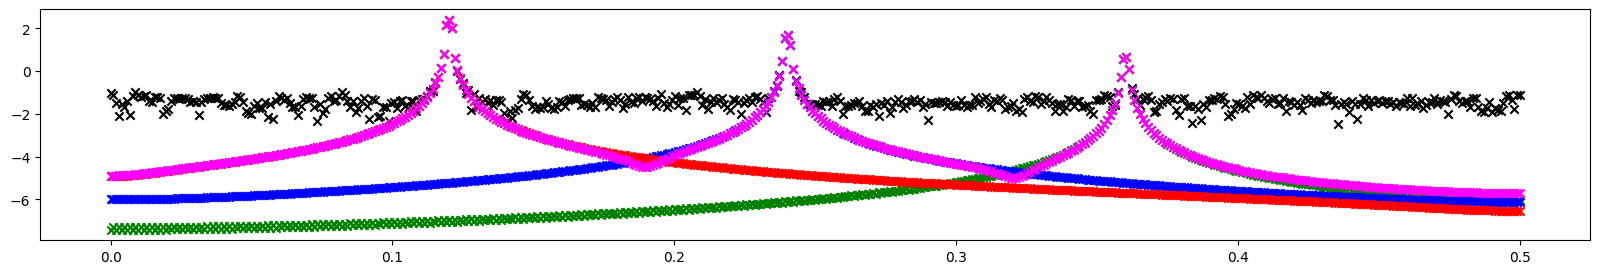

In [5]:
# Plot spectrum

grid = torch.fft.rfftfreq(size).cpu().numpy()

plt.figure(figsize=(20, 3))
plt.scatter(grid, torch.fft.rfft(signal*win.window).abs().log10().cpu().numpy(), color='black', marker='x')
plt.scatter(grid, torch.fft.rfft(s3*win.window).abs().log10().cpu().numpy(), color='green', marker='x')
plt.scatter(grid, torch.fft.rfft(s2*win.window).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.scatter(grid, torch.fft.rfft(s1*win.window).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(grid, torch.fft.rfft((s1 + s2 + s3)*win.window).abs().log10().cpu().numpy(), color='magenta', marker='x')

plt.show()

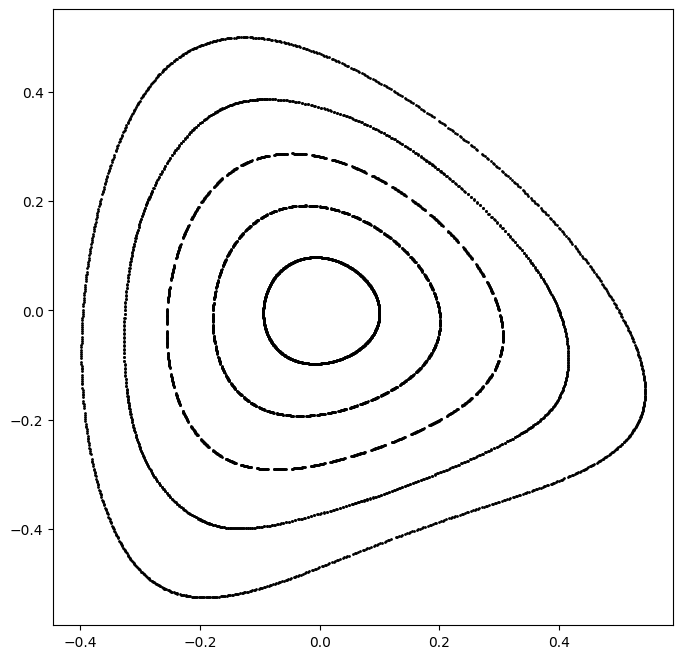

In [6]:
# Define nonlinear map

amplitude = torch.tensor(1.0, dtype=dtype, device=device)

nux = torch.tensor(2.0*numpy.pi*0.38, dtype=dtype, device=device)
nuy = torch.tensor(2.0*numpy.pi*0.41, dtype=dtype, device=device)

cx, sx = nux.cos(), nux.sin()
cy, sy = nuy.cos(), nuy.sin()


@torch.func.vmap
def henon(state:torch.tensor) -> torch.tensor:
    local = torch.clone(state)
    local[0] = cx*state[0] + sx*(amplitude*(state[0]**2 -state[2]**2) + state[1])
    local[1] = cx*(amplitude*(state[0]**2 - state[2]**2) + state[1]) - sx*state[0]
    local[2] = cy*state[2] + sy*(state[3] - 2.0*amplitude*state[0]*state[2])
    local[3] = cy*(state[3] - 2.0*amplitude*state[0]*state[2]) + sy*state[2]
    return local

# Generate test trajectories

state = torch.tensor(
    [
        [0.10, 0.0, 0.0, 0.0],
        [0.20, 0.0, 0.0, 0.0],
        [0.30, 0.0, 0.0, 0.0],
        [0.40, 0.0, 0.0, 0.0],
        [0.50, 0.0, 0.0, 0.0]
    ], 
    dtype=dtype, device=device)

qx, px = [], []
qx.append(state[:, 0])
px.append(state[:, 1])

count = 2**10 - 1
for _ in range(count):
    state = henon(state)
    qx.append(state[:, 0])
    px.append(state[:, 1])

qx = torch.stack(qx).cpu().numpy()
px = torch.stack(px).cpu().numpy()

plt.figure(figsize=(8, 8))
for qxi, pxi in zip(qx, px):
    plt.scatter(qxi, pxi, color='black', marker='o', s=1)
plt.show()

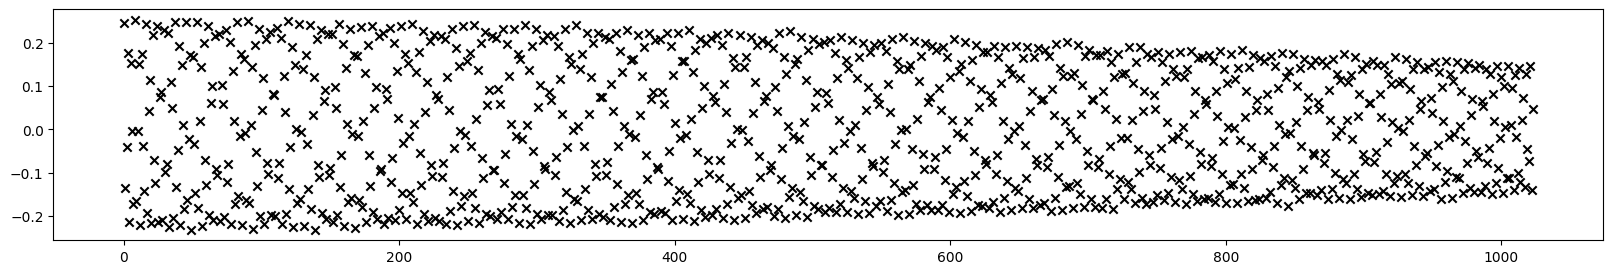

In [7]:
# Generate initial distribution

qx = 0.25 + 0.01*torch.randn(2**20, dtype=dtype, device=device)
px = 0.00 + 0.01*torch.randn(2**20, dtype=dtype, device=device)
qy = torch.zeros_like(qx)
py = torch.zeros_like(px)

# Track distribution

orbit = []

state = torch.stack([qx, px, qy, py]).T
orbit.append(state[:, 0].mean())

count = 2**10 - 1
for _ in range(count):
    state = henon(state)
    orbit.append(state[:, 0].mean())
    
orbit = torch.stack(orbit)

# Add noise & remove mean

orbit += 0.005*torch.randn_like(orbit)
orbit -= orbit.mean()

# Plot centroid

plt.figure(figsize=(20, 3))
plt.scatter(range(count + 1), orbit.cpu().numpy(), color='black', marker='x')
plt.show()

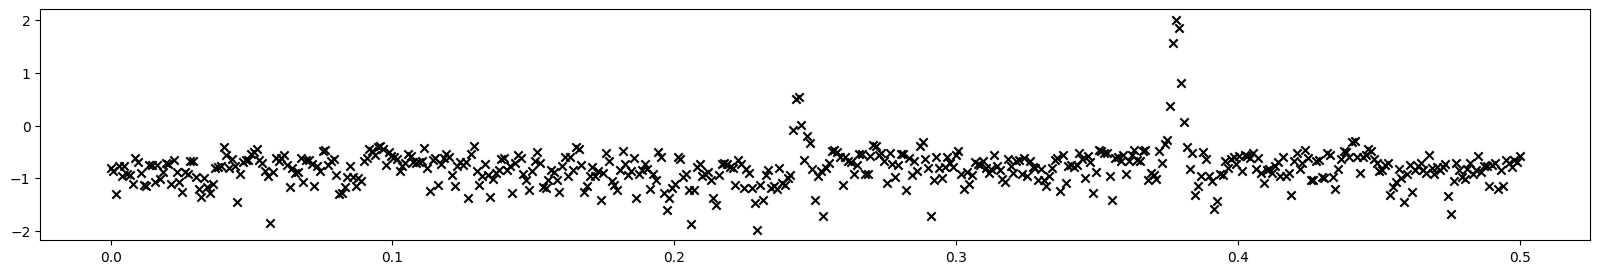

In [8]:
# Plot centroid spectrum

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.rfftfreq(size).cpu().numpy(), torch.fft.rfft(orbit*win.window).abs().log10().cpu().numpy(), color='black', marker='x')

plt.show()

In [9]:
# Set window & data

win = Window(size, 'cosine_window', 1.0, dtype=dtype, device=device)
tbt = Data.from_data(win, orbit.reshape(1, -1))
tbt.add_noise(torch.tensor([0.001], dtype=dtype, device=device))

# Estimate signal rank and noise

flt = Filter(tbt)
rank, noise = flt.estimate_noise(limit=64)
print(rank)
print(noise)

tensor([4])
tensor([5.139350577897e-03], dtype=torch.float64)


In [10]:
# Perform decompostion
# Note, here only two components are used
# In fact, the third component for this example should be combined with the first one
# In general, components with close frequencies should be merged

s1, s2, *_ = Decomposition.decomposition_hsvd(2, orbit, np=2, ni=8)

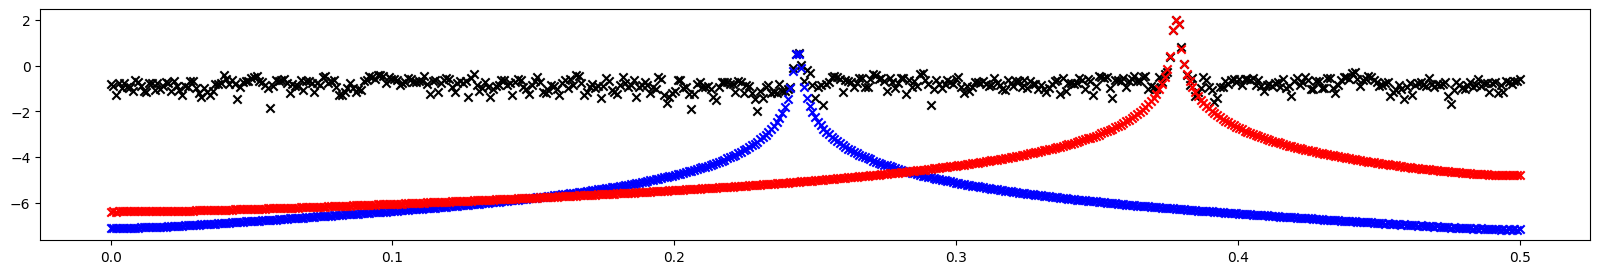

In [11]:
# Plot spectrum

grid = torch.fft.rfftfreq(len(orbit)).cpu().numpy()

plt.figure(figsize=(20, 3))
plt.scatter(grid, torch.fft.rfft(orbit*win.window).abs().log10().cpu().numpy(), color='black', marker='x')
plt.scatter(grid, torch.fft.rfft(s2*win.window).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.scatter(grid, torch.fft.rfft(s1*win.window).abs().log10().cpu().numpy(), color='red', marker='x')

plt.show()

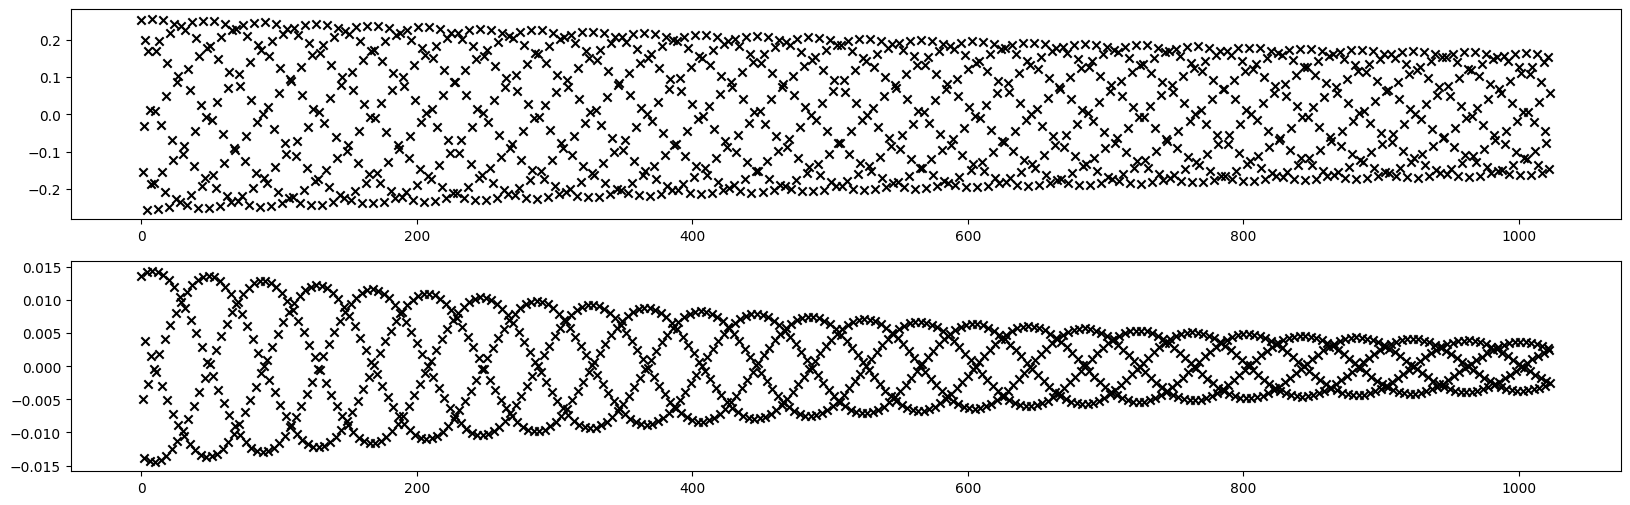

In [12]:
# Plot components

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.scatter(range(len(s1)), s1.cpu().numpy(), color='black', marker='x')

ax = plt.subplot(212)
ax.scatter(range(len(s2)), s2.cpu().numpy(), color='black', marker='x')

plt.show()

# Example-11: Quasiperiodic decomposition

In [1]:
# Import

import numpy
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# Define nonlinear map

amplitude = torch.tensor(1.0, dtype=dtype, device=device)

nux = torch.tensor(2.0*numpy.pi*0.38, dtype=dtype, device=device)
nuy = torch.tensor(2.0*numpy.pi*0.41, dtype=dtype, device=device)

cx, sx = nux.cos(), nux.sin()
cy, sy = nuy.cos(), nuy.sin()

@torch.func.vmap
def henon(state:torch.tensor) -> torch.tensor:
    local = torch.clone(state)
    local[0] = cx*state[0] + sx*(amplitude*(state[0]**2 -state[2]**2) + state[1])
    local[1] = cx*(amplitude*(state[0]**2 - state[2]**2) + state[1]) - sx*state[0]
    local[2] = cy*state[2] + sy*(state[3] - 2.0*amplitude*state[0]*state[2])
    local[3] = cy*(state[3] - 2.0*amplitude*state[0]*state[2]) + sy*state[2]
    return local

# Generate test trajectories

state = torch.tensor([[0.00625*i, 1.0E-12, 0.0, 0.0] for i in range(80 + 1)], dtype=dtype, device=device)

qx, px = [], []
qx.append(state[:, 0])
px.append(state[:, 1])

count = 2**12 - 1
for _ in range(count):
    state = henon(state)
    qx.append(state[:, 0])
    px.append(state[:, 1])

qx = torch.stack(qx)
px = torch.stack(px)

In [4]:
# Set window & data

win = Window.from_cosine(2**12, 4.0, dtype=dtype, device=device)
tbt = Data.from_data(win, qx.T)
print(tbt)

Data(81, Window(4096, 'cosine_window', 4.0))


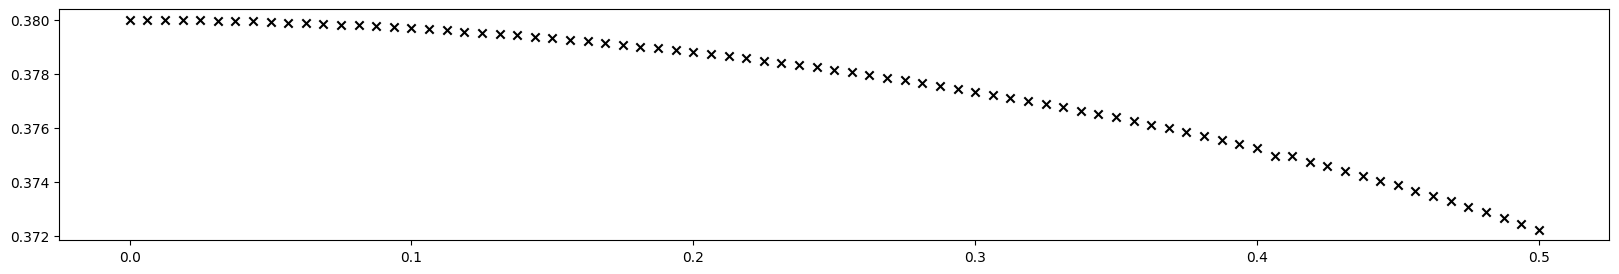

In [5]:
# Estimate main frequency

fre = Frequency(tbt)
fre.data.window_remove_mean()
fre.data.window_apply()
fre('parabola')
fre.data.reset()

# Plot frequency vs initial amplitude

plt.figure(figsize=(20, 3))
plt.scatter(tbt.data[:, 0].cpu().numpy(), fre.frequency.cpu().numpy(), color='black', marker='x')
plt.show()

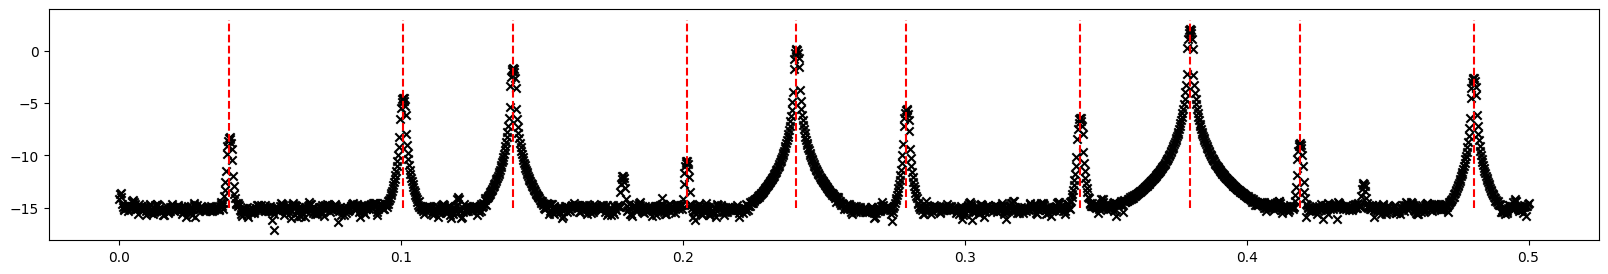

In [6]:
# Each (stable) orbit is an infinite sum of (fast) decaying harmonics of fundamental frequencies
# With these initial conditions, the motion is 2d and only one fundamental frequency is present
# This frequency also corresponds to a frequency with the largest amplitude
# Note, this is not always the case for higher dimensions

# Select an orbit to decompose & plot correponding spectrum
# Several harmonics of fundamental frequency can be seen

index = 10

table = Frequency.harmonics(10, [fre.frequency[index].cpu().item()]).values()

plt.figure(figsize=(20, 3))
plt.scatter(fre.fft_grid.cpu().numpy(), fre.fft_spectrum[index].log10(), color='black', marker='x')
plt.vlines(table, -15.0, 3.0, linestyles='dashed', color='red')
plt.show()

In [7]:
# Estimate parameters for several first harmonics
# Estimate frequency of the largest peak, estimate corresponding parameters using harmonic sums, subtract and cycle

index = 20
limit = 5

signal = torch.clone(qx.T[index])
signal = signal - signal.mean()

table = []

win = Window.from_cosine(2**12, 4.0, dtype=dtype, device=device)

for _ in range(limit):
    tbt = Data.from_data(win, signal.reshape(1, -1))
    fre = Frequency(tbt)
    dec = Decomposition(tbt)
    fre.data.window_remove_mean()
    fre.data.window_apply()
    fre('parabola')
    f = fre.frequency.squeeze()
    parameter, _ = dec.harmonic_sum(f, win.window, tbt.data)
    c, s, *_ = parameter.squeeze()
    table.append(torch.stack([f, c, s]))
    signal -= Data.make_harmonic(len(signal), f, c=c, s=s)

table = torch.stack(table)

In [8]:
# Identify harmonics

order = 100
for key, value in Frequency.identify(order, table[0:1, 0].cpu().numpy().tolist(), table[:, 0].cpu().numpy().tolist()).items():
    print(key, value)

(1,) [0.3795181678866871, 0.3795181678866871, 0.0]
(2,) [0.24096366422662585, 0.2409636642266249, 9.43689570931383e-16]
(3,) [0.13855450366006128, 0.13855450366006306, 1.7763568394002505e-15]
(4,) [0.4819273284532517, 0.4819273284532494, 2.275957200481571e-15]
(5,) [0.10240916056656468, 0.10240916056682584, 2.6115221096745245e-13]


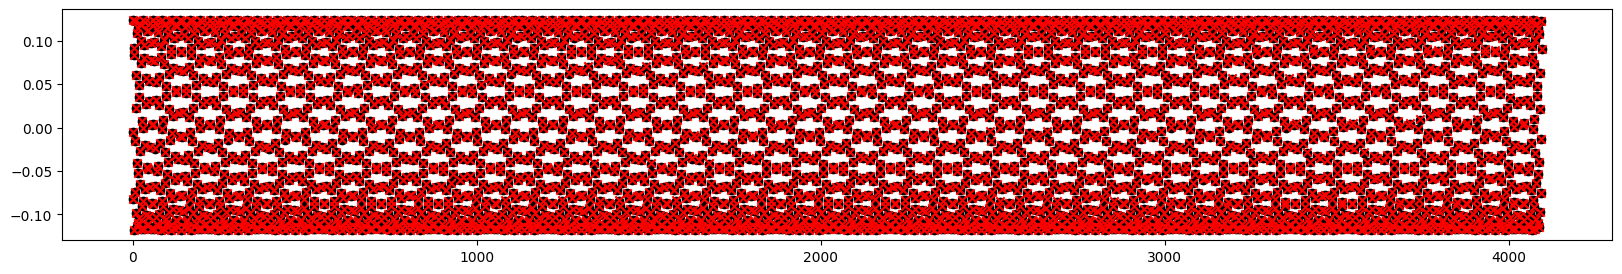

In [9]:
# Reconstruct & plot signal

orbit = torch.zeros_like(signal)
for f, c, s in table:
    orbit += Data.make_harmonic(len(orbit), f, c=c, s=s)

plt.figure(figsize=(20, 3))
plt.scatter(range(2**12), (qx.T[index] - qx.T[index].mean()).cpu().numpy(), color='black', marker='o')
plt.scatter(range(2**12), orbit.cpu().numpy(), color='red', marker='x')
plt.show()

In [10]:
# Perform OLS fit using known frequencies & compare with harmonic sums

print(table[:, 1:])
print()

basis, *_ = table.T
parameter, _ = Decomposition.fit_ols(qx.T[index] - qx.T[index].mean(), basis)

print(parameter)
print()

tensor([[ 1.203385639339e-01,  8.406875786513e-03],
        [ 3.147664601766e-03, -4.419498514376e-04],
        [ 9.291890686852e-05,  1.973121020299e-05],
        [-2.037960696311e-05,  5.837910432968e-06],
        [-4.767901119451e-07,  1.733584581808e-07]], dtype=torch.float64)

tensor([[ 1.203385493933e-01,  8.406869629688e-03],
        [ 3.147665160002e-03, -4.419504421696e-04],
        [ 9.290617497004e-05,  1.969900386287e-05],
        [-2.037964814153e-05,  5.836729689680e-06],
        [-4.957158166936e-07,  1.313839214466e-07]], dtype=torch.float64)



In [11]:
# Use main frequency to construct dictionary and estimate parameters

order = 10
table = torch.tensor([*Frequency.harmonics(order, [basis[0].item()]).values()], dtype=dtype, device=device)
signal = qx.T[index] - qx.T[index].mean()

# Harmonic sum

result, _ = Decomposition.harmonic_sum_batched(table, win.window, signal.reshape(1, -1))
c, s, *_ = result.squeeze().T
print(torch.stack([c, s]).T)
print()

# OLS

result, _ = Decomposition.fit_ols(signal, table)
print(result)
print()

# OMP

result, _ = Decomposition.fit_omp(signal, table, tol=1.0E-9)
print(result)
print()

tensor([[ 1.203385639339e-01,  8.406875786513e-03],
        [ 3.147664601771e-03, -4.419498513990e-04],
        [ 9.291890686944e-05,  1.973121020098e-05],
        [-2.037960696314e-05,  5.837910432198e-06],
        [-4.767901106958e-07,  1.733584595600e-07],
        [-7.121666337637e-08, -3.167376619211e-08],
        [-2.271379446563e-08,  1.206362255802e-08],
        [-5.333707106850e-10, -3.328938443932e-10],
        [ 3.130836501955e-10,  2.271836080288e-10],
        [ 1.148310440230e-11, -9.622515368346e-12]], dtype=torch.float64)

tensor([[ 1.203385494358e-01,  8.406869679625e-03],
        [ 3.147665207560e-03, -4.419504718067e-04],
        [ 9.290623442212e-05,  1.969899868934e-05],
        [-2.037963483656e-05,  5.836741689936e-06],
        [-4.956559969359e-07,  1.313951326130e-07],
        [-7.288402135975e-08, -3.012160924216e-08],
        [-3.813673363711e-08,  6.416834818030e-09],
        [-2.109933612688e-08, -1.314414133911e-09],
        [-1.312976546141e-08, -6.20603407